<a href="https://colab.research.google.com/github/Enzo2806/Logistic-Multiclass/blob/main/Logistic-Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Task 1: Data preprocessing

In [ ]:
# Suppress std_out
%%capture

# Instal packages
!pip install matplotlib numpy pandas # Plotting
!pip install scipy sklearn # Result analysis and data splitting
!pip install seaborn # Heatmaps
!pip install -U scikit-learn # Scikit learn for pre-processing

In [ ]:
# Imports
import os.path
from os import path # Check if the dataset exists in the local environment
import pandas as pd # Pre-processing
import numpy as np # Data manipulation
import matplotlib.pyplot as plt # Visualization
from sklearn.datasets import fetch_20newsgroups # Import the dataset from sklearn
from sklearn.feature_extraction.text import CountVectorizer # Import for text preprocessing and filtering stopwords.
from sklearn.feature_extraction.text import TfidfTransformer # Import to go from occurences to frequencies when processing text data
from sklearn.datasets import load_svmlight_file # To pre-process the Imdb reviews (Instead of read_csv since the inputs are not in csv format)
from sklearn.utils import shuffle # To shuffle the inputs
from numpy.linalg.linalg import sqrt # Square root function
from sklearn.metrics import mutual_info_score # Import MI to select features 
from scipy.sparse import diags # To create diagonal matrices
from sklearn.preprocessing import StandardScaler # To standardize data
from scipy.sparse import vstack # To verticlly stack sparse matrices
from sklearn.model_selection import train_test_split # For splitting into training and validation sets
from sklearn.model_selection import GridSearchCV # Sklearn hyperparameter optimization tool used for KNN 
from sklearn.neighbors import KNeighborsClassifier # Sklearn KNN Classifier
from sklearn.metrics import accuracy_score # Sklearn accuracy function
from sklearn.metrics import roc_curve, roc_auc_score # ROC curve plotting
from math import sqrt # To compute the z-scores
import seaborn as sns # Heatmaps


%matplotlib inline
pd.options.mode.chained_assignment = None # Disable chained assignment warnings

We will start by setting a seed for all mp.random processes to ensure reproducibility.

In [ ]:
np.random.seed(1)

## 1.1 IMDB Reviews

We'll start by downloading the dataset [1] if it wasn't done already:

In [ ]:
# Suppress std_out
%%capture

# Download and untar the file if it wasn't done already
if not path.exists("aclImdb"):
  !wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz # type: ignore
  !tar -xvf /content/aclImdb_v1.tar.gz # type: ignore

The Imdb dataset above is composed as follows:
- There are two folders in the dataset, one for the training and one for the testing data.
- In each folder, we can find one folder for the positive reviews, another for the negative reviews, with each document in either folder representing one review.
- The name of a review document is its `id` in the folder followed by the review value associated with it (0-10).
- In the main dataset folder, we can also find `imdb.vocab` which holds every word that will represent each of our ~ 83000 features (The value of the feature will be the frequency of that word in the input review), and the index of the feature will be the row in which it appears in the file
- Finally, the `labeledBow` file in both the train and test folders holds the frequencies of every word from `imdb.vocab` for each input, along with that input's review value, in the following format (on every new line): 
`REVIEW_VALUE [<FeatureWordIndex>: <Frequency of that word>]`.
- For the above, since `labeledBow` lines are not numbered, and thus we cannot know which one is for which input review, it is good to note that all the positive reviews are included first, followed by all the negative reviews.

We will start by using `load_svmlight_file` to convert the input data into a sparse `Scipy` matrix, before visualizing the first resulting entry and understanding its composition.

In [ ]:
# Extracting labeledBow of the training and testing data as a pandas dataframe
X_train_imdb, y_train_imdb = load_svmlight_file("aclImdb/train/labeledBow.feat")
print(f"Shape of the training set inputs: {X_train_imdb.shape}")
print(f"First input of the training set: \n {X_train_imdb[0]}")
print(f"Shape of the training set labels: {y_train_imdb.shape}")
print(f"Label of the first input of the training set: {y_train_imdb[0]}")

Shape of the training set inputs: (25000, 89527)
First input of the training set: 
   (0, 0)	9.0
  (0, 1)	1.0
  (0, 2)	4.0
  (0, 3)	4.0
  (0, 4)	6.0
  (0, 5)	4.0
  (0, 6)	2.0
  (0, 7)	2.0
  (0, 8)	4.0
  (0, 10)	4.0
  (0, 12)	2.0
  (0, 26)	1.0
  (0, 27)	1.0
  (0, 28)	1.0
  (0, 29)	2.0
  (0, 32)	1.0
  (0, 41)	1.0
  (0, 45)	1.0
  (0, 47)	1.0
  (0, 50)	1.0
  (0, 54)	2.0
  (0, 57)	1.0
  (0, 59)	1.0
  (0, 63)	2.0
  (0, 64)	1.0
  :	:
  (0, 1477)	2.0
  (0, 1940)	1.0
  (0, 1941)	1.0
  (0, 2096)	1.0
  (0, 2243)	1.0
  (0, 2285)	1.0
  (0, 2379)	1.0
  (0, 2934)	1.0
  (0, 2938)	1.0
  (0, 3520)	1.0
  (0, 3647)	1.0
  (0, 4938)	1.0
  (0, 5138)	4.0
  (0, 5715)	1.0
  (0, 5726)	1.0
  (0, 5731)	1.0
  (0, 5812)	1.0
  (0, 8319)	1.0
  (0, 8567)	1.0
  (0, 10480)	1.0
  (0, 14239)	1.0
  (0, 20604)	1.0
  (0, 22409)	4.0
  (0, 24551)	1.0
  (0, 47304)	1.0
Shape of the training set labels: (25000,)
Label of the first input of the training set: 9.0


As we can see, `X_train[0]` (1st input review) has 2 columns:
- Column 1 is a tuple in the format (`index_of_training_example`, `index_of_feature_word`)
- Column 2 is a number which represents the number of occurences of the word repreented by `index_of_feature_word`in the `index_of_training_example`th input review

Now that we have our training dataset ready, we move on to similarly extracting the testing dataset's features and labels:

In [ ]:
# Extract the inputs and labels of the testing dataset
X_test_imdb, y_test_imdb = load_svmlight_file("aclImdb/test/labeledBow.feat")

# Visualize the first input of the testing set
print(f"Shape of the testing set inputs: {X_test_imdb.shape}")
print(f"First input of the testing set: \n {X_test_imdb[0]}")
print(f"Shape of the testing set labels: {y_test_imdb.shape}")
print(f"Label of the first input of the testing set: {y_test_imdb[0]}")

Shape of the testing set inputs: (25000, 89523)
First input of the testing set: 
   (0, 0)	7.0
  (0, 1)	4.0
  (0, 2)	2.0
  (0, 3)	5.0
  (0, 4)	5.0
  (0, 5)	1.0
  (0, 6)	3.0
  (0, 7)	1.0
  (0, 8)	6.0
  (0, 9)	3.0
  (0, 10)	4.0
  (0, 11)	6.0
  (0, 12)	1.0
  (0, 14)	2.0
  (0, 15)	4.0
  (0, 16)	1.0
  (0, 19)	2.0
  (0, 20)	2.0
  (0, 21)	1.0
  (0, 26)	1.0
  (0, 30)	2.0
  (0, 34)	1.0
  (0, 44)	1.0
  (0, 45)	1.0
  (0, 48)	1.0
  :	:
  (0, 1383)	1.0
  (0, 1409)	1.0
  (0, 1615)	2.0
  (0, 1619)	1.0
  (0, 1773)	1.0
  (0, 1818)	1.0
  (0, 1867)	1.0
  (0, 1868)	1.0
  (0, 2081)	1.0
  (0, 2300)	1.0
  (0, 2510)	1.0
  (0, 2653)	1.0
  (0, 2909)	1.0
  (0, 2956)	1.0
  (0, 2984)	1.0
  (0, 3009)	1.0
  (0, 5447)	1.0
  (0, 7282)	1.0
  (0, 9702)	1.0
  (0, 12605)	1.0
  (0, 12803)	1.0
  (0, 13914)	1.0
  (0, 14176)	1.0
  (0, 15612)	2.0
  (0, 26903)	1.0
Shape of the testing set labels: (25000,)
Label of the first input of the testing set: 10.0


We can see above that, for `X_test`, we only have `89523` features, meaning that feature words with indices `89523` to `89527`, inclusive, were not used at all in the testing dataset reviews, and thus were omitted from the sparse matrix.

We thus have `25000` training inputs, `25000` testing inputs, and a total of `89527` features, with only a few being non-zero for every input since there are only so many words you can have in one review (Definitely not `89527`). Furthermore, it must be noted that, for each of `training` and `testing` datasets:
- Inputs with indices `0` to `12499` (Inclusive) represent the corresponding sentences from the pos folder of the dataset with corresponding indices `0` to `12499`.
- Inputs with indices `15000` to `24999` (Inclusive) represent the corresponding sentences from the neg folder of the dataset with corresponding indices `0` to `12499`.

<br><br>We can thus derive the following formula for finding the textual review corresponding to a particular input (Will be useful for inspecting the results of z-score feature selection later on in the notebook):

Given the index i (Row index) of any input from `X_train` or `X_test`
- If i <= 12499, the corresponding review is located in the `pos` folder of the dataset with name `i_rating.txt`
- If i >= 12500, the corresponding review is located in the `neg` folder of the dataset with name `(i-12500)_rating.txt`

We will now proceed to extracting the word corresponding to every feature into a pandas dataframe, for future use (When we need to know what each feature represents):

In [ ]:
# Extract the data
imdb_feature_words = pd.read_csv("aclImdb/imdb.vocab", header=None)

# Rename the only column
imdb_feature_words.columns = ["Word"]

# Show the first 5 entries
imdb_feature_words.head()

,Word
0,the
1,and
2,a
3,of
4,to


Note that the row index of each word is the number used to represent the feature's number of occurences in `X_train` and `X_test`.

The next step now consists of eliminating words that appear less than 1% of the documents, as well as words that appear in more than 50% of the documents because they are "rare words" and "stopwords" respectively. To accomplish this goal, we will start by computing `imdb_word_usage`, where entry with index `i` corresponds to the number of documents word with index `i` is used in. The `bincount` method of doing things is inspired by [2].

In [ ]:
# Array that will hold in how many documents each word is used
imdb_word_usage = np.zeros(imdb_feature_words.shape[0])

# Iterate through both X_train and X_test
for dataset in (X_train_imdb, X_test_imdb):
  # Iterate through every input in either X_train or X_test
  for input in dataset:
    # used_words will have 89527 entries (1 for each word) where index i will be 0 if word with index 
    # i wasn't used, and 1 if word with index i was used in the input
    # Note: input.indices returns the indices of the words from imdb_feature_words used in the input
    used_words = np.bincount(input.indices, minlength=89527)
    imdb_word_usage += used_words

We then proceed to dividing the resulting number of occurences by `50000` since our training and testing datasets combined contain `50000` reviews, in order to get the frequency representing the proportion of reviews it appears in.

In [ ]:
# Convert counts to frequencies
imdb_word_usage /= 50000

# Visualize the results as a sanity check
imdb_word_usage

array([9.9118e-01, 9.6594e-01, 9.6648e-01, ..., 2.0000e-05, 2.0000e-05,
       2.0000e-05])

Since the results above look like the correct frequencies (all between 0 and 1), we now move on to filtering out "rare words" and "stopwords":

In [ ]:
# Compute boolean array to locate rare words and stop words in imdb_feature_words
words_to_remove = np.logical_or(imdb_word_usage < 0.01, imdb_word_usage > 0.5)

# Filter out the above words
removed_feature_words = imdb_feature_words[words_to_remove]
imdb_feature_words = imdb_feature_words[np.logical_not(words_to_remove)]

# Visualize removed words
print("Removed words: ")
print(removed_feature_words)

# Visualize remaining words
print("Remaining words: ")
print(imdb_feature_words)

Removed words: 
                    Word
0                    the
1                    and
2                      a
3                     of
4                     to
...                  ...
89522          copywrite
89523             artbox
89524          kinky-sex
89525           urrrghhh
89526  investigator-like

[87791 rows x 1 columns]
Remaining words: 
            Word
21            he
23           his
27             !
30            by
31            an
...          ...
2012  references
2014       stock
2039       board
2047      leader
2051       plots

[1736 rows x 1 columns]


The removed words correctly look like stopwords (e.g. "The", "And",
"a", "of", "to", etc.) and rare words (e.g. "copywrite", "urrrghhh", "investigator-like", etc.) which confirms our results, and we are left with `1736` features.

We then re-index the above remaining word dataframe to start from 0 again, since we don't need the old indices anymore.

In [ ]:
# Re-index, dropping old indices
imdb_feature_words.reset_index(inplace=True, drop=True)

# Sanity check
print(f"Remaining number of features: {imdb_feature_words.shape[0]}")
imdb_feature_words.head()

Remaining number of features: 1736


,Word
0,he
1,his
2,!
3,by
4,an


We can see that the re-indexing was successful, and we are left with `1736` features, which we'll further trim later using hypothesis testing and z-scores.

We will now proceed to remove the columns corresponding to the above filtered words from the `X_train` and `X_test` sparse input matrices by using a method involving matrix multiplication for efficiency [3], as explained in the comments accompanying the code:

In [ ]:
# np.logical_not(words_to_remove).astype(int) is an array where boolean at index i is 1 if word i should be kept, 0 otherwise
# diags(np.logical_not(words_to_remove).astype(int)) is thus a diagonal matrix where element (i,i) is 1 if word i should be kept, 0 otherwise
# By performing matrix multiplication between X_train_imdb and the diagonal matrix, we are only keeping the columns of valid words (Not stop / rare words)
# Stop word and rare word columns are set to all zeros, and will be removed in the next step below
X_train_imdb = X_train_imdb@diags(np.logical_not(words_to_remove).astype(int))

# The next step is now to remove columns that have all zeros
indices = np.nonzero(X_train_imdb) # A tuple of two elements: First has indices of non-all zero rows, second non-all zero columns
columns_to_keep_non_unique = indices[1] # Extract a list of indices of the non-all zero columns
columns_to_keep_unique = sorted(set(columns_to_keep_non_unique)) # Make the list unique
X_train_imdb = X_train_imdb[:,columns_to_keep_unique] # Make a sparse matrix of the columns to keep (Not all zero)

# The same applies to X_test with one difference
# Since only the first 89523 features were used in the testing dataset as seen before,
# we cannot perform the below matrix multiplication because of a size mismatch
# Therefore, our diagonal matrix here must be composed using words_to_remove without its 5 last elements (Since those are not even features due not appearing at all in the testing set)
X_test_imdb = X_test_imdb@diags(np.logical_not(words_to_remove[:-4]).astype(int))

# Now we delete the columns with all zeros
indices = np.nonzero(X_test_imdb) # A tuple of two elements: First has indices of non-all zero rows, second non-all zero columns
columns_to_keep_non_unique = indices[1] # Extract a list of indices of the non-all zero columns
columns_to_keep_unique = sorted(set(columns_to_keep_non_unique)) # Make the list unique
X_test_imdb = X_test_imdb[:,columns_to_keep_unique] # Make a sparse matrix of the columns to keep (Not all zero)

# Sanity check, visualize the first entry of X_train after filtering out unused words
print(f"The first entry of the training dataset is now \n {X_train_imdb[0]}")

The first entry of the training dataset is now 
   (0, 1718)	1.0
  (0, 1430)	2.0
  (0, 1373)	1.0
  (0, 1360)	2.0
  (0, 1163)	1.0
  (0, 1150)	1.0
  (0, 1030)	1.0
  (0, 850)	1.0
  (0, 739)	1.0
  (0, 644)	1.0
  (0, 592)	1.0
  (0, 544)	1.0
  (0, 487)	1.0
  (0, 441)	1.0
  (0, 363)	2.0
  (0, 343)	1.0
  (0, 330)	1.0
  (0, 316)	1.0
  (0, 294)	5.0
  (0, 228)	1.0
  (0, 203)	1.0
  (0, 190)	1.0
  (0, 186)	1.0
  (0, 181)	1.0
  (0, 180)	1.0
  :	:
  (0, 123)	1.0
  (0, 115)	1.0
  (0, 113)	1.0
  (0, 109)	1.0
  (0, 98)	1.0
  (0, 95)	1.0
  (0, 89)	1.0
  (0, 79)	1.0
  (0, 73)	1.0
  (0, 51)	1.0
  (0, 45)	1.0
  (0, 43)	1.0
  (0, 41)	2.0
  (0, 39)	1.0
  (0, 37)	1.0
  (0, 36)	2.0
  (0, 32)	1.0
  (0, 30)	1.0
  (0, 27)	2.0
  (0, 23)	1.0
  (0, 20)	1.0
  (0, 18)	1.0
  (0, 14)	1.0
  (0, 5)	1.0
  (0, 2)	1.0


The above results show that the most common stopwords ("The" with index 0, "And" with index 1) have been removed, confirming the effectiveness of the procedure.

We'll now proceed to filter further by computing the z-scores of each feature with respect to the output variable. The process will go as follows:

- We will start by standardizing the inputs and their corresponding outputs

- The next step then consists of emitting the following null hypothesis for every feature d out of the 1736 we have left:
>> *H0 = "Weight of feature d in a simple regression follows N(0,1)", or in other words, "Feature d is not correlated to the output because its corresponding weight is too small".*

- We will the proceed to compute the z-score of the weight of that feature using the formula seen in class, which is equivalent to fitting a simple regression between feature d and the response variable:
>> $z_d = \frac{1}{\sqrt{N}}*\overrightarrow{\tilde{\dot{{x_d^T}}}}*\overrightarrow{\tilde{\dot{{y}}}}$

- In a normal p-value test, the next step would then be to compute the probability of observing more extreme results that contradict  *H0* assuming N(0,1), and only keep the features with with such a probability that is smaller than $\alpha$, usually 0.05. However, for this assignment, we will instead sort the features by their absolute z-score, and keep only the 400 features with the highest absolute results.

- Finally, since we have the data split between training and testing, we will need to first join the two sets together before standardizing it.

To effectively complete the above, we will start by standardizing the data after joining together the train and test sets.

In [ ]:
# Merge the y's into a single vertical output vector
all_y = np.concatenate((y_train_imdb, y_test_imdb)).reshape(-1, 1)

# Standardize the output vector
standardized_y = StandardScaler().fit_transform(all_y)

# Visualize the result's shape as a sanity check
print(standardized_y.shape)

(50000, 1)


The resulting array has 50000 rows and 1 column, which mean the process was successful. We now move on to standardizing the inputs in similar fashion.

In [ ]:
# Merge the X's into a single matrix
all_X = vstack((X_train_imdb, X_test_imdb)).toarray() # We convert to a numpy array because the number of features is now small enough

# Standardize the output vector
standardized_X = StandardScaler().fit_transform(all_X)

# Visualize the result's shape as a sanity check
print(standardized_X.shape)

(50000, 1736)


Again, the output has 50000 rows (1 for every input) and 1736 columns (1 for every feature). Now that both our inputs and outputs are standardized, we proceed to compute the z-score of every feature.

Text(0, 0.5, 'z-score')

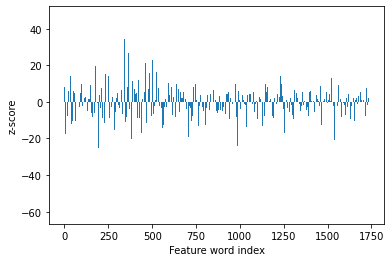

In [ ]:
# Create a list to hold the zscores, where zscore at index i is zscore of feature i
zscores = np.zeros(standardized_X.shape[1])

# Iterate over the coluns of standardized_X
for i in range(standardized_X.shape[1]):
  zscores[i] = (np.dot(standardized_X[:, i], standardized_y)/sqrt(standardized_X.shape[0]))

# We can now visualize the features wrt their absolute zscore
plt.bar(np.arange(standardized_X.shape[1]), zscores)
plt.xlabel("Feature word index")
plt.ylabel("z-score")

We can now inspect the feature words with the most positive z-scores to see if they really correlated with having a positive review:

In [ ]:
# Extract the 10 words with the most postive z-scores
most_positive_word_indices = np.argsort(-zscores) # We use - so that the most positive become the most negative and appear first
most_positive_words = imdb_feature_words.iloc[most_positive_word_indices[:10]]

# Append their corresponding z-scores to the dataframe as a column
most_positive_words["z-score"] = (-np.sort(-zscores)[:10]).tolist()
most_positive_words

,Word,z-score
56,great,46.806802
282,excellent,36.995621
88,best,35.231665
342,wonderful,34.588314
87,love,29.790638
410,loved,28.008016
432,amazing,27.716057
365,perfect,26.721903
466,favorite,26.402529
843,superb,26.072888


As can be seen above, all the words above are very much characteristic of a good review, and all have a very positive connotation.

We can now do the same to words with a strongly negative z-score:

In [ ]:
# Extract the 10 words with the most negative z-scores
most_negative_word_indices = np.argsort(zscores)
most_negative_words = imdb_feature_words.iloc[most_negative_word_indices[:10]]

# Append their corresponding z-scores to the dataframe as a column
most_negative_words["z-score"] = np.sort(zscores)[:10].tolist()

# Print the results
most_negative_words

,Word,z-score
50,bad,-61.229505
213,worst,-59.187551
400,waste,-46.945639
341,awful,-43.687852
19,?,-39.073873
346,terrible,-38.854331
395,worse,-35.599683
476,horrible,-34.275638
336,stupid,-33.807844
28,no,-33.284108


Again, all the words listed above are very harsh, and hold a negative connotation, validating the results. It is to be noted that "?" is here, because in general negative reviews question the movie sarcastically.

We can now proceed to only keep to 400 features with the highest absolute z-scores.

In [ ]:
# Sort features in descending order of ABSOLUTE zscore
features_descending_order = np.argsort(-np.absolute(zscores)) # Negative of the absolute array so that the smallest element for argsort is actually the biggest zscore

# The indices of the features to keep
feature_indices_to_keep = features_descending_order[:500]

# Only keep those features in the Imdb words array and reset the indexing
imdb_feature_words = imdb_feature_words.iloc[feature_indices_to_keep]
imdb_feature_words.reset_index(inplace = True, drop=True)

# Convert X_train and X_test to numpy arrays
X_train_imdb = X_train_imdb.toarray()
X_test_imdb = X_test_imdb.toarray()

# Only keep the columns corresponding to the feature indices to keep
X_train_imdb = X_train_imdb[:, feature_indices_to_keep]
X_test_imdb = X_test_imdb[:, feature_indices_to_keep]

# Print the shapes of X_train and X_test
print(f"X_train has shape {X_train_imdb.shape} and X_test has shape {X_test_imdb.shape}")

X_train has shape (25000, 500) and X_test has shape (25000, 500)


The above dimensions corresponding to what we were expecting, which confirms the correctness of the process.

We can now finally move on to shuffling both the training and testing inputs, as well as their corresponding labels, since all the positive reviews are placed at the start followed by all negative reviews (not random):

In [ ]:
# Shuffle both datasets with a seed for reproducibility
X_train_imdb, y_train_imdb = shuffle(X_train_imdb, y_train_imdb, random_state=2)
X_test_imdb, y_test_imdb = shuffle(X_test_imdb, y_test_imdb, random_state=2)

Since we are doing binary classification, we need to convert ratings that are greater or equal to 7 into a `1` to signify a `positive` review, and ratings that are smaller than or equal to 4 into a `0` to signify a `negative` review, as specified in the readme.md of the dataset:

In [ ]:
# Transform negative reviews
# Note: Important to start with negative reviews, otherwise positive are sent to 1
# and can't be differentiated from negative anymore for the second step
y_train_imdb[y_train_imdb <= 4] = 0

# Transform positive reviews
y_train_imdb[y_train_imdb >= 7] = 1

# Visualize the labels
print(y_train_imdb)

[0. 1. 1. ... 1. 1. 0.]


We can do the same for the testing dataset, as shown below:

In [ ]:
# Convert the labels to be binary
y_test_imdb[y_test_imdb <= 4] = 0
y_test_imdb[y_test_imdb >= 7] = 1

The last step in pre-processing the IMDB reviews is to separate the training dataset into training and validation. We will also print the shape of all datasets as a verification step.

In [ ]:
X_train_imdb, X_validate_imdb, y_train_imdb, y_validate_imdb = train_test_split(X_train_imdb, y_train_imdb, test_size = 0.3, random_state=5, shuffle = True)

print("Training data has: ", X_train_imdb.shape[0], " documents and ", X_train_imdb.shape[1], " words (features).")
print("Training label has: ", y_train_imdb.shape[0], " documents.")

print("Validation data has: ", X_validate_imdb.shape[0], " documents and ", X_validate_imdb.shape[1], " words (features).")
print("Validation label has: ", y_validate_imdb.shape[0], " documents")

print("Testing data has: ", X_test_imdb.shape[0], " documents and ", X_test_imdb.shape[1], " words (features).")
print("Testing data has: ", y_test_imdb.shape[0], " documents.")

Training data has:  17500  documents and  500  words (features).
Training label has:  17500  documents.
Validation data has:  7500  documents and  500  words (features).
Validation label has:  7500  documents
Testing data has:  25000  documents and  500  words (features).
Testing data has:  25000  documents.


Finally, we conclude by visualizing the proportions of the data within the testing set to infer whether it is balanced or not.

Text(0.5, 1.0, 'Distribution of the data for the IMdB reviews dataset')

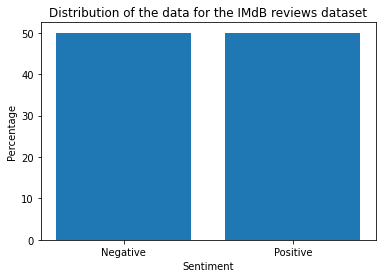

In [ ]:
# Extract the prercentages of each of the two classes
_ , counts = np.unique(y_test_imdb, return_counts=True)
counts = (counts / y_test_imdb.shape[0]) * 100

# Plot the results
plt.bar(["Negative", "Positive"], counts)
plt.ylabel("Percentage")
plt.xlabel("Sentiment")
plt.title("Distribution of the data for the IMdB reviews dataset")

This concludes the pre-processing section for the Imdb reviews dataset.

Here are the names of the variables to use in order to run experiments on the IMDB reviews data:

`X_train_imdb`, `y_train_imdb`, `X_validate_imdb`, `y_validate_imdb`, `X_test_imdb`, `y_test_imdb`

## 1.2  20 News Groups

### 1.2.1 Training pre-processing 

We will first extract the raw data from the training twenty news dataset in [4], and create a list to keep track of our four selected categories. We will also print the first loaded document and its category to check if the importation was successful. The following pre-processing steps are taken from the scikit learn tutorial mentionned in the assignemnt directives [4].

In [ ]:
# As recommended by the assignment directives, we split the dataset by keeping our 4 favorite categories
# List to keep track of the selected categories
# The list is in alphabetical order because when we get the samples from sklearn, 
# Each category is converted to an index depending on alphabetical order. 
# Thus, 'comp.graphis' corresponds to 0 in the y_train_twenty matrix, 
# 'rec.sport.hockey' corresponds to 1 etc... 
categories_twenty = ['comp.graphics','rec.sport.hockey', 'sci.med', 'soc.religion.christian']

# We shuffle randomly to select only a subset of samples to quickly train the model and get a first idea of the results before re-training on the complete dataset later
df_train_twenty = fetch_20newsgroups(subset='train', categories=categories_twenty, shuffle=True, random_state=42, remove=(['headers', 'footers', 'quotes']))

y_train_twenty = df_train_twenty.target

# Print the shape of the data.
# The files themselves are loaded in memory in the data attribute
print("The length of the data is the number of documents which is: ",len(df_train_twenty.data), "\n")

# Print the first loaded file
print("\n".join(df_train_twenty.data[0].split("\n")))

# Print the category of the first loaded file
print("\nThe category of the first file is:", df_train_twenty.target_names[df_train_twenty.target[0]])

# Print the target vector
print("\nThe labels are:\n", y_train_twenty)

The length of the data is the number of documents which is:  2377 

It is not true that dermatologists gave not reached the laser age, in
fact, lasers in dermatological surgery is a very new and exciting field.

It probably won't be effective in tinea pedis because the laser is
usually a superficial burn (to avoid any deeper damage). Limited tinea
pedis can be cured albeit sometimes slowly by topical antifungals as
well as systemic medication i.e. tablets. Finally, a self-diagnosis is
not always reliable, lichen simplex chronicus can look like a fungal
infection and requires very different treatment.

The category of the first file is: sci.med

The labels are:
 [2 3 0 ... 2 1 3]


After a successful import, we will visiualize if the proportion of training examples in each of the four classes we chose is equivalently divided. To do so, we will visualize a pie chart of the class distribution. The following function will also be used for the testing dataset later in the code.

In [ ]:
# Visualizing class Distribution
from collections import Counter

def get_distribution (dataset):
  if dataset == "training":
    # Counter counts the proportions of training examples for each categories
    _, values = zip(*Counter(df_train_twenty.target).items())

    label_twenty = df_train_twenty.target_names
  elif dataset == "test":
    # Counter counts the proportions of training examples for each categories
    _, values = zip(*Counter(df_test_twenty.target).items())

    label_twenty = df_test_twenty.target_names

  # plot the labels
  colors = ['aquamarine', 'cyan', 'azure', 'blue'] # One color for each category

  patches = plt.pie(values, colors=colors, startangle=90, autopct='%1.1f%%')

  plt.legend(label_twenty, loc="best")

  plt.axis('equal')
  plt.tight_layout()

  plt.title('Class distribution for the four different categories.')
  plt.show()

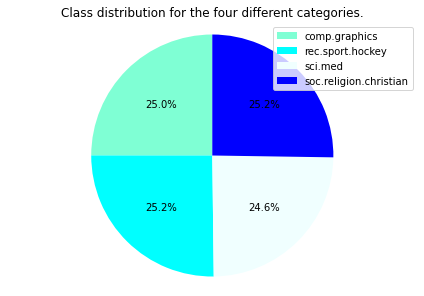

In [ ]:
get_distribution("training")

We notice how well distributed the training examples are between the four categories. 

Since we have text data, we need to convert it to feature vectors in order to perform machine learning on it. We will use the bag of words representation which consists of the following:

- We first assign a fixed integer id to each word occurring in all documents of the training set.

- Then, for each document `i`, we count the number of occurrences of each word w and store it in a matrix `X` at `X[i, j]` as the value of feature `j` where `j` is the index of word w in the dictionary.

This representation means that the number of features equals the number of total words, which can be typically larger than 100,000. Therefore, storing the feature matrix could take few gigabytes if the number of samples is very high (10 000 or more) [4].

However, most values in the matrix `X` will be zeros since less than a few thousand distinct words will be used for each given document. Thus, bags of words are high-dimensional sparse datasets. We can save a lot of memory by only storing the non-zero parts of the feature vectors in memory.`scipy.sparse` matrices are data structures that do exactly this, and `scikit-learn` has built-in support for these structures.

We will now use the sklearn `CountVectorizer` [5] which builds a dictionary of features and transforms documents to feature vectors. More specifically, it converts a collection of text documents to a matrix of token counts and does so by lowercasing all words and ignoring single characters by default.

When creating the `CountVectorizer` object, we specify two parameters `max_df` and `min_df` that do the following:
- `max_df`: ignore terms that have a document frequency strictly higher than the given threshold (50%) when building the vocabulary.
- `min_df`: ignore terms that have a document frequency strictly lower than the given threshold (1%) when building the vocabulary.

In [ ]:
count_vect = CountVectorizer(min_df = 0.01, max_df = 0.5) # Create the object and sets the min/max frequency of the words to ignore.
X_train_twenty_count = count_vect.fit_transform(df_train_twenty.data) # Use the object and fit it on the twenty newsgroup data.

print("Shape of the matrix containing the token counts is: ", X_train_twenty_count.shape)
print("This is interpreted as the following: ", X_train_twenty_count.shape[0], " docs and ", X_train_twenty_count.shape[1], " unique words.")
print("\nFirst element of the list is:\n", X_train_twenty_count[0])

Shape of the matrix containing the token counts is:  (2377, 1586)
This is interpreted as the following:  2377  docs and  1586  unique words.

First element of the list is:
   (0, 944)	3
  (0, 1451)	1
  (0, 599)	1
  (0, 105)	1
  (0, 531)	1
  (0, 1363)	1
  (0, 1494)	2
  (0, 927)	1
  (0, 552)	1
  (0, 1084)	1
  (0, 1554)	1
  (0, 199)	2
  (0, 477)	1
  (0, 202)	1
  (0, 1485)	1
  (0, 185)	1
  (0, 140)	1
  (0, 800)	1
  (0, 264)	2
  (0, 1292)	1
  (0, 256)	1
  (0, 168)	2
  (0, 1521)	1
  (0, 557)	1
  (0, 1236)	1
  (0, 123)	1
  (0, 816)	1
  (0, 798)	1
  (0, 1171)	1
  (0, 421)	1
  (0, 1448)	1


Thus, by removing stopwords and rare words using the given thresholds in the assignment directives, we are left with a total of 1586 words as features. We will now visualize the 40 words with the most occurrences in the first document in a table. 

We note here that the elements in the first column that appear when we print `X_train_twenty_count[0]` correspond to (index of the document in the slice, word id). If we print `X_train_twenty_count[1:2]`, the left element in the parentheses will be 0 for all the words in document 1, and then 1 for all words in document 2.

We do not save the result of the countvectorizer in the `X_train_twenty` variable but in `X_train_twenty_count` because we need it in a separate variable for the coputation of mutual information.



In [ ]:
feature_names = count_vect.get_feature_names_out () 
# get tfidf vector for first document 
first_document_occurences_vector = X_train_twenty_count[0] 

# print the scores
occurences_table_twenty = pd.DataFrame(first_document_occurences_vector.T.todense(), index=feature_names, columns=["Occurences"]) # Create a data frame 
occurences_table_twenty.sort_values(by=["Occurences"],ascending=False).head(40) # Sort by frequencies of all words

,Occurences
not,3
as,2
very,2
be,2
can,2
limited,1
avoid,1
by,1
self,1
sometimes,1


This table shows us the number of occurences of each word in the first document. We notice how some words that were present in the original document (when we printed it in the first pre-processing step) are not present in the table. This includes words like "a" that were removed by the `CountVectorizer` because of their 1-charactr length. The word "chronicus" is also not in the table for example, which is likely due to the thresholds we set in the parameters of `CountVectorizer`.

However, there is an issue with just working with occurrences: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics. 

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called `tf` for Term Frequencies. Thus, we now move from the occurences of the words to their frequencies using sklearn's `TfidfTransformer` [4][6].

Another refinement on top of `tf` is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus. This downscaling is called `tf–idf` for “Term Frequency times Inverse Document Frequency”.

In [ ]:
tfidf_transformer = TfidfTransformer(use_idf = True)
X_train_twenty = tfidf_transformer.fit_transform(X_train_twenty_count)

print("Shape of the matrix containing the frequencies is: ", X_train_twenty.shape)
print("This is interpreted as the following:", X_train_twenty.shape[0], " docs and ", X_train_twenty.shape[1], " unique words.")
print("\nFrequencies of each words for the first document is:\n", X_train_twenty[0])

Shape of the matrix containing the frequencies is:  (2377, 1586)
This is interpreted as the following: 2377  docs and  1586  unique words.

Frequencies of each words for the first document is:
   (0, 1554)	0.1700093002855999
  (0, 1521)	0.1229216068441266
  (0, 1494)	0.23818654971864536
  (0, 1485)	0.18134047923527927
  (0, 1451)	0.15416359841938104
  (0, 1448)	0.1948633555266898
  (0, 1363)	0.23523189822535318
  (0, 1292)	0.19239043055635832
  (0, 1236)	0.20998328467761507
  (0, 1171)	0.2179404305638748
  (0, 1084)	0.14614392172050591
  (0, 944)	0.23240167808386974
  (0, 927)	0.13282238885206005
  (0, 816)	0.15367621018227945
  (0, 800)	0.2082061105934154
  (0, 798)	0.10563013918264823
  (0, 599)	0.20251152994717359
  (0, 557)	0.19817090449762442
  (0, 552)	0.22506462015480855
  (0, 531)	0.15465662132737187
  (0, 477)	0.20406246473916825
  (0, 421)	0.1564285203782834
  (0, 264)	0.17374393492557075
  (0, 256)	0.09347961729740371
  (0, 202)	0.12062825827407393
  (0, 199)	0.1471823430470

We will now visualize the 40 words with the highest tfidf in the first document in a table as follow.

In [ ]:
feature_names = count_vect.get_feature_names_out() 

#get tfidf vector for first document 
first_document_vector = X_train_twenty[0]

#print the scores
frequency_table_twenty = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["Term Frequency times Inverse Document Frequency"]) # Create a data frame 
frequency_table_twenty.sort_values(by=["Term Frequency times Inverse Document Frequency"],ascending=False).head(40) # Sort by frequencies of all words

,Term Frequency times Inverse Document Frequency
very,0.238187
surgery,0.235232
not,0.232402
field,0.225065
requires,0.217940
avoid,0.214780
age,0.212796
self,0.209983
limited,0.208206
effective,0.204062


We can compare this table to the table of the occurrences and notice that even though the word "not" had the highest occurrency in the first document and "very" the second highest, it's "very" that has the highest tfidf while "not" is onlt the third word. Thus, taking into account downscale weights for words and frequencies significantly changed the importance of some features.

Since we are dealing with discrete class labels, we will use something different from simple regression to select features externally. 
Thus, we will use Mutual Information (MI) from sklearn [7] to select the top 200 feature words per class and take the
union of all top feature words to train our multiclass model. Notice that we  filtered rare stopwords first, as such words would have high mutual information. If we haven't filtered them out, we would have ended up choosing wrong features with mutual information and get low accuracy later.

To use mutual information, we will first convert the list containing the label to one-hot encoded so that we get 4 columns of y (e.g,. y1, y2, y3, y4) according to the 4 categroies we picked. 
Then, we calculate the mutual information of each feature (each column of `X_train_twenty_count`) with y1,y2,y3 and y4 respectively. Notice we use the feature columns of `X_train_twenty_count` instead of `X_train_twenty` because the `mutual_info_score` function raises a warning if the label data is not discrete. Afterwards, we choose the 200 features that have the highest MI for each class, leaving us with a total of 800 features or less. It is possible that we get less than 800 features if some features are important to more than one catgeory. 

In [ ]:
print("Before one hot encoding:\n", y_train_twenty)

y_train_twenty_onehot = np.zeros((y_train_twenty.size, y_train_twenty.max() + 1))
y_train_twenty_onehot[np.arange(y_train_twenty.size), y_train_twenty] = 1

# Since the y_train_twenty_onehot array contains floats, we convert its values to integers 
y_train_twenty_onehot = (np.rint(y_train_twenty_onehot)).astype(int)

print("After one hot encoding:\n", y_train_twenty_onehot)

# Set the training labels to one hot encoded
y_train_twenty = y_train_twenty_onehot

Before one hot encoding:
 [2 3 0 ... 2 1 3]
After one hot encoding:
 [[0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 ...
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]]


We will also convert our datasets `X_train_twenty_count` and `X_train_twenty` of type `scipy.sparse.csr_matrix` to numpy arrays to better manipulate them. However, transitionning to a numpy array will not use the built-in feature of scikit-learn that ignores the zero values in the matrix[105]. Therefore, X will now hold a lot of zero values as every document only has a few thousand words on average.

In [ ]:
X_train_twenty_count = np.asarray(X_train_twenty_count.todense())
X_train_twenty = np.asarray(X_train_twenty.todense())

print(X_train_twenty)
print("\nThe shape of the training array is: ", X_train_twenty.shape)
print("So we still have ", X_train_twenty.shape[0], " documents and ", X_train_twenty.shape[1], " words (features).")

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.05935572 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.0704896  ... 0.14674361 0.         0.        ]
 [0.         0.         0.14819041 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

The shape of the training array is:  (2377, 1586)
So we still have  2377  documents and  1586  words (features).


We will now proceed to keep the top 100 features for each category using mutual information. Again, we use the `X_train_twenty_count` dataframe to compute the score, but after selecting the top ~400 features, the algorithm also deletes the other features in the `X_train_twenty` dataframe. 

In [ ]:
number_words = X_train_twenty_count.shape[1] # Number of features = number of words
number_categories = y_train_twenty_onehot.shape[1] # Number of catgeories

scores = np.zeros((number_words, number_categories)) # Array to store the mutual info score of all features with the given category
ind = np.asarray([]) # Array to keep track of the indices of the 100 highest mutual information scores for all categories
# We will just append the index of the columns of X_train_twenty_count corresponding to the 100 best words to the 'ind' array for each category
# Since we are dealing with 400 catgeories the array has shape (400,1).

j = 0
i = 0

# loop over all categories (y1,y2,y3,y4)
for category in y_train_twenty_onehot.T: 
  # Loop over each columns of features
  for features in X_train_twenty_count.T:
    scores[i][j] = mutual_info_score(features, category)
    i+=1

  # Save indices of the 200 highest mutual information scores for that category
  indices = np.argpartition(scores[:, j], -100)[-100:]
  ind = np.append(ind, indices)

  j+=1 # Reset counters
  i=0

# We now remove duplicates in the index array to make sure that if a feature is 
# considered best for more than one category, we delete it.
ind = np.unique(ind)

# Since the index array contains floats, we convert its values to integers 
ind = (np.rint(ind)).astype(int)

# Keep the top features in both X_train_twenty_count and X_train_twenty dataframes
X_train_twenty_count = X_train_twenty_count[:, ind]
X_train_twenty = X_train_twenty[:, ind]

# Also remove the features in the array containg the feature names
feature_names_twenty = feature_names[ind]

print(X_train_twenty)
print("\nThe new shape of the training array is:", X_train_twenty.shape)
print("So we now still have ", X_train_twenty.shape[0], " documents but ", X_train_twenty.shape[1], " words (features).\n")

print("The shape of the array holding the feature names is: ", feature_names_twenty.shape)
print("The array holding the feature names now has the follwing words: \n", feature_names_twenty)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.16766055 0.05935572]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.0704896  0.         0.         ... 0.         0.06908381 0.14674361]
 [0.14819041 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.07328712 0.         0.        ]]

The new shape of the training array is: (2377, 297)
So we now still have  2377  documents but  297  words (features).

The shape of the array holding the feature names is:  (297,)
The array holding the feature names now has the follwing words: 
 ['10' '256' '3d' 'abc' 'about' 'acts' 'advance' 'after' 'again'
 'algorithm' 'algorithms' 'all' 'animation' 'any' 'are' 'as' 'available'
 'banks' 'bay' 'be' 'beat' 'because' 'been' 'being' 'belief' 'beliefs'
 'believe' 'bible' 'biblical' 'blood' 'brain' 'bruins' 'buffalo' 'but'
 'by' 'cadre' 'calgary' 'can' 

### 1.2.2 Testing pre-processing 

We will now pre-process the testing set of the 20 news groups dataset. Most of the steps are identical to the ones we performed on the training dataset.

In [ ]:
# Import the testing dataset
df_test_twenty = fetch_20newsgroups(subset='test', categories=categories_twenty, shuffle=True, random_state=42, remove=(['headers', 'footers', 'quotes']))

# Labels of the testing dataset
y_test_twenty = df_test_twenty.target

# Print the shape of the testing data.
print("The number of documents in the testing data is: ",len(df_test_twenty.data), "\n")

# Print the first loaded file
print("\n".join(df_test_twenty.data[0].split("\n")))
# Print the category of the first loaded file
print("\nThe category of the first file is:", df_test_twenty.target_names[df_test_twenty.target[0]])
# Print the target vector
print("\nThe labels are:\n", y_test_twenty)

The number of documents in the testing data is:  1582 

Wow, this guy seems to be out to prove something to his old team, Boston.
Which Sweeney you ask...well, of course Bob Sweeney, the one that Boston
let Buffalo get a hold of (they still have 2 Sweeneys which makes things
slightly confusing).  Game winner in OT in game 1, and another
BIG goal (seconds after Fuhr made 3 point blank saves -> this is why
Grant has 5 rings!!!) to put Buffalo ahead in the 3rd.  Yes, Neely countered
a minute later, but hadn't this course of Buffalo going ahead after being
tied and shutting down another few great scoring opportunities, I
think Boston would have notched their first win of the series.

Well, the Sabres haven't made it to the end of this series yet, but
I certainly feel they've got Boston right were they want them...actually,
they've got them in a position that neither Buffalo nor Boston felt
that would come about.  One more astronomical game by Fuhr, a few more
heroics by the rest of the tea

After a successful import, we will visiualize if the proportion of training examples in each of the four classes we chose is equivalently divided for the test dataset. To do so, we will visualize a pie chart of the class distribution using the function we defined earlier.

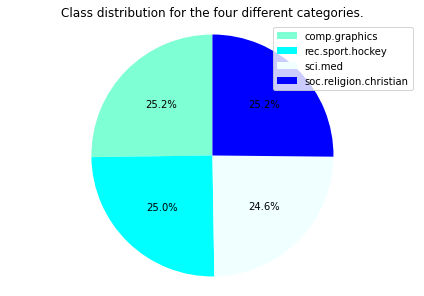

In [ ]:
get_distribution("test")

Again, we notice how well distributed the training examples are between the four categories even for the testing data. 

Since the 20 news groups testing set also has text data, we need to convert it to feature vectors by performing countvectorizer's operations as we did for training. Notice that for the testing data, we use the `.transform` function instead of `.fit_transform` so that the count_vect object makes sure the two feature vectors have the same number of features.

In [ ]:
# Use the count_vect object we created for training and fit it on the twenty newsgroup testing data.
# Reminder: count_vect sets the min/max frequencies of the words to ignore to 1% and 50% respectively
X_test_twenty = count_vect.transform(df_test_twenty.data) 
X_test_twenty = tfidf_transformer.transform(X_test_twenty)

print("Shape of the matrix containing the frequencies is: ", X_test_twenty.shape)
print("This is interpreted as the following:", X_test_twenty.shape[0], " docs and ", X_test_twenty.shape[1], " unique words.")
print("\nFrequencies of each words for the first document is:\n", X_test_twenty[0])

Shape of the matrix containing the frequencies is:  (1582, 1586)
This is interpreted as the following: 1582  docs and  1586  unique words.

Frequencies of each words for the first document is:
   (0, 1581)	0.022978550163455517
  (0, 1579)	0.04837535017646725
  (0, 1578)	0.04933768339796798
  (0, 1568)	0.053700301468653656
  (0, 1554)	0.04984812817515435
  (0, 1551)	0.042910288309618246
  (0, 1542)	0.054160069011427836
  (0, 1537)	0.03947868590502585
  (0, 1534)	0.05276928580256037
  (0, 1533)	0.029516772928721284
  (0, 1530)	0.06250212339202402
  (0, 1527)	0.06466529061949158
  (0, 1523)	0.03511003676003032
  (0, 1522)	0.05623557383450204
  (0, 1521)	0.07208325665911768
  (0, 1507)	0.10450494051201292
  (0, 1504)	0.0416588286662681
  (0, 1492)	0.11982556774944353
  (0, 1478)	0.043274512913456235
  (0, 1474)	0.06686465171270586
  (0, 1473)	0.05071082612334329
  (0, 1435)	0.11464715614003129
  (0, 1429)	0.05139930242212327
  (0, 1415)	0.19092169255587696
  (0, 1412)	0.06497531510163342
 

Now that the test data is converted to feature vectors, we need it to have the same features as the train data. So, any features that were removed in training data will be excluded in test data. From the earlier computation, the array ind hold the index of the top features we selected for the trianing dataset.

We also convert the array storing the labels to one-hot encoded and we convert the `X_test_twenty_count` and `X_test_twenty` of type `scipy.sparse.csr_matrix` to numpy arrays to better manipulate them. 

In [ ]:
X_test_twenty = X_test_twenty[:, ind]

print(X_test_twenty)
print("\nThe new shape of the testing array is:", X_test_twenty.shape)
print("So we now still have ", X_test_twenty.shape[0], " documents but ", X_test_twenty.shape[1], " words (features).")

  (0, 295)	0.022978550163455517
  (0, 293)	0.053700301468653656
  (0, 287)	0.054160069011427836
  (0, 286)	0.03947868590502585
  (0, 285)	0.029516772928721284
  (0, 284)	0.06250212339202402
  (0, 283)	0.06466529061949158
  (0, 281)	0.03511003676003032
  (0, 279)	0.10450494051201292
  (0, 263)	0.19092169255587696
  (0, 262)	0.08408720485888319
  (0, 261)	0.216673541271845
  (0, 258)	0.034982442176958735
  (0, 257)	0.033292924628377
  (0, 253)	0.1313317813617961
  (0, 248)	0.04008421981453901
  (0, 241)	0.049438118963170415
  (0, 230)	0.1018722648213359
  (0, 226)	0.06297527266485232
  (0, 224)	0.13436515112591554
  (0, 206)	0.06456019635374416
  (0, 176)	0.02420317683375861
  (0, 174)	0.10908482410133716
  (0, 172)	0.022714029208567462
  (0, 163)	0.09616005886072146
  :	:
  (1581, 172)	0.06755343311454944
  (1581, 169)	0.09011236532983562
  (1581, 166)	0.1253726067457872
  (1581, 163)	0.04766468368433646
  (1581, 155)	0.04374089219013586
  (1581, 154)	0.055543101717684756
  (1581, 146)	

In [ ]:
print("Before one hot encoding:\n", y_test_twenty)

y_test_twenty_onehot = np.zeros((y_test_twenty.size, y_test_twenty.max() + 1))
y_test_twenty_onehot[np.arange(y_test_twenty.size), y_test_twenty] = 1

# Since the y_test_twenty_onehot array contains floats, we convert its values to integers 
y_test_twenty_onehot = (np.rint(y_test_twenty_onehot)).astype(int)

print("After one hot encoding:\n", y_test_twenty_onehot)
y_test_twenty = y_test_twenty_onehot

X_test_twenty = np.asarray(X_test_twenty.todense())

Before one hot encoding:
 [1 2 1 ... 1 1 3]
After one hot encoding:
 [[0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 ...
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]]


As a last step of pre-processing, we will split the training datasets into training and validation and print the shape of all variables of the 20 news groups data.

In [ ]:
X_train_twenty, X_validate_twenty, y_train_twenty, y_validate_twenty = train_test_split(X_train_twenty, y_train_twenty, test_size = 0.3, random_state=5, shuffle = True)

print("Training data has: ", X_train_twenty.shape[0], " documents and ", X_train_twenty.shape[1], " words (features).")
print("Training label has: ", y_train_twenty.shape[0], " documents and ", y_train_twenty.shape[1], " labels.")

print("Validation data has: ", X_validate_twenty.shape[0], " documents and ", X_validate_twenty.shape[1], " words (features).")
print("Validation label has: ", y_validate_twenty.shape[0], " documents and ", y_validate_twenty.shape[1], " labels.")

print("Testing data has: ", X_test_twenty.shape[0], " documents and ", X_test_twenty.shape[1], " words (features).")
print("Testing data has: ", y_test_twenty.shape[0], " documents and ", y_test_twenty.shape[1], " labels.")

Training data has:  1663  documents and  297  words (features).
Training label has:  1663  documents and  4  labels.
Validation data has:  714  documents and  297  words (features).
Validation label has:  714  documents and  4  labels.
Testing data has:  1582  documents and  297  words (features).
Testing data has:  1582  documents and  4  labels.


We notice that all X matrices correclty have the same number of features, and that corresponding X and y matrices have the same number of training examples (documents).

 The pre-processing on the data is now completed, we will therefore move on to the implementation of our models: logisitic and multiclass classifiers. 

Here are the names of the variables to use in order to run experiments on the 20 news groups data:

`X_train_twenty`, `y_train_twenty`, `X_validate_twenty`, `y_validate_twenty`,`X_test_twenty`, `y_test_twenty`

# Task 2: Implement Logistic and Multiclass classifiers

In this section, we will implement Logistic and Multiclass Regression models. 

The Multi-class Regression model is a classification model that outputs probabilities for $C$ classes using a softmax function. It is learned by minimizing the Cross-Entropy cost function. 

The Logistic Regression model is a special case of the Multiclass Regression model when $C=2$. It outputs class probabilities using a logistic function, which is a reduction from the softmax function when $C=2$. It is also learned by minimizing the Cross-Entropy cost function, which is a reduced form of Cross-Entropy from the multi-class case. 

Both models will be trained using gradient descent. We will add three different dimensions to our algorithm since we know that there exist better alternatives to the generic full-batch gradient descent. 

To start, we know that for full-batch training, a very small learning rate could influence the convergence to be slower. In contrast, for online training, the algorithm approaches the optima faster. However, the weights oscillate near the global minimum and the algorithm does not converge. Therefore, we will experiment with mini-batch stochastic gradient descent that will update the weights based on mini-batches, making the best out of the two options. 

Next, to make the stochastic gradient descent converge near the global optima, we will implement Adaptive Moment Estimate (Adam) [9]. We choose Adam since it is the algorithm that combines momentum and parameter adaptive learning rate. 

Finally, we will implement L2-regularization to our Losigtic and Multiclass regression models by adding a hyperparameter λ. This hyperparameter will control the strength of the regularization on the weights. 

## 2.1 Logistic Regression

In this subsection, we introduce the Logistic Regression algorithm. 

In [ ]:
class LogisticRegression:
    def __init__(self, bias=True, verbose=True):
      self.bias = bias 
      self.verbose = verbose

    def logistic():
      pass

    def cross_entropy_ridge_cost():
      pass

    def create_mini_batches():
      pass

    def adam_parameters_update():
      pass

    def regularized_gradient():
      pass

    def small_perturbation():
      pass
      
    def fit():
      pass
    
    def predict():
      pass


First, let us define the logistic function used to calculate the probabilities of the logistic regression model. The function below shows how we compute the outputs.

$$
\overrightarrow{\hat{y}} = \frac{1}{1 + exp(-(\overrightarrow{x}⋅\overrightarrow{w}))}
$$

In [ ]:
def logistic(self, X, w):
  return  1/ (1 + np.exp(-(np.dot(X, w))))

LogisticRegression.logistic = logistic

Define cost function to be the Cross-Entropy cost for Logistic Regression with a ridge regression L2-norm penalty.

$$
J(\overrightarrow{w}) = \displaystyle\sum_{(n)} y^{(n)}log(\hat{y}^{(n)}) -  (1-y^{(n)})log(1-\hat{y}^{(n)}) + \frac{λ}{2}||\overrightarrow{w}||_2^2
$$

In [ ]:
def cross_entropy_ridge_cost(self, X, y, lambda_):
  z = np.dot(X, self.w)
  return np.sum(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z))) + (lambda_/2)*(np.inner(self.w, self.w)) # The L2-norm square is just the inner product of vector w with itself

LogisticRegression.cross_entropy_ridge_cost = cross_entropy_ridge_cost

Next, define a helper method that creates mini-batches from the input data [10]. In the implementation of the method, we will concatenate the result `y` to each example in `X` such that `y` is at the last index. Then, we will shuffle the numpy array and extract the number of batches such that each mini-batch is of equal size. We assume that `batch_size` is always smaller than the number of samples. 

In [ ]:
def create_mini_batches(self, X, y, batch_size):

  # Append the result to the ent of each training example
  X_y_concat = np.column_stack([X, y])

  # Shuffle the data 
  np.random.shuffle(X_y_concat)

  # Number of batches with equal size
  num_batches = X_y_concat.shape[0]//batch_size

  # The output will have less datapoints if batch size is not a multiple of input data size
  return np.array_split(X_y_concat[:batch_size*num_batches], num_batches)

LogisticRegression.create_mini_batches = create_mini_batches

To update the weights of our model, we will be using Adaptive Moment Estimation (Adam) [9]. From module 4.4, the gradient descent formula is:

$$
\overrightarrow{w}^{\{t\}} = \overrightarrow{w}^{\{t-1\}} - \frac{α}{ \sqrt{\hat{S}^{\{t\}} + ϵ}} \hat{M}^{\{t\}}
$$
Where, 
$$
\hat{M}^{\{t\}} ⟵ \frac{M^{\{t\}}}{1 - β_1^{t}}
$$

$$
\hat{S}^{\{t\}} ⟵ \frac{S^{\{t\}}}{1 - β_2^{t}}
$$
and 
$$
M^{\{t\}} = β_1 M^{\{t-1\}} + (1-β_1)\frac{\partial J_B(\overrightarrow{w}^{\{t-1\}})}{\partial \overrightarrow{w}^{\{t-1\}}}
$$

$$
S^{\{t\}} = β_2 S^{\{t-1\}} + (1-β_2)(\frac{\partial J_B(\overrightarrow{w}^{\{t-1\}})}{\partial \overrightarrow{w}^{\{t-1\}}})^{2}
$$

We will set $\beta_1=0.9$ and $\beta_2=0.999$ [9]. We precise the  parameter $B$ which indicates the weight updates for the corresponding batch. The ϵ parameter is a stabilizer that will be set to $1e-10$ to prevent a division by zero when $\hat{S}^{\{t\}}$ gets very small. Furthermore, we will add an optional regularization parameter λ to the function that will allow us to penalize large weights of the model. 

We will encode our gradient from the derivation seen in module 4.2 and add the λ hyperparameter seen in module 4.5. The gradient will be the sum of the gradients over the points in the minibatch. Since we are computing with mini-batches, we have our sum over the number of training examples in a batch B. We can write the formula as: 

$$ 
\frac{\partial J_B(\overrightarrow{w})}{\partial \overrightarrow{w}} =  X_B^T(\sigma (X_B\overrightarrow{w}) - \overrightarrow{y_B}) + λ\overrightarrow{w}
$$

In [ ]:
def adam_parameters_update(self, gradient, m_init, s_init, t):
  # Using values from reference for beta1 and beta 2
  beta1 = 0.9
  beta2 = 0.999

  # Update biased first and second moment estimate
  m = beta1 * m_init + (1 - beta1)*gradient
  s = beta2 * s_init + (1 - beta2)*(gradient)**2

  # Update bias-corrected first and second moment estimates
  m_hat = m / (1 - beta1**t)
  s_hat = s / (1 - beta2**t)

  return m, s, m_hat, s_hat

LogisticRegression.adam_parameters_update = adam_parameters_update

In [ ]:
def regularized_gradient(self, X, y, lambda_):
  y_hat = self.logistic(X, self.w)
  gradient = np.dot(X.T, (y_hat - y)) + (lambda_*self.w)
  return gradient

LogisticRegression.regularized_gradient = regularized_gradient

We will also implement a function that will verify gradient calculation using small perturbation test using the given procedure below:

1. $\epsilon \sim Uniform([0,1])$
2. $w^{(+)}_d = w_d + \epsilon$
3. $w^{(-)}_d = w_d - \epsilon$
4. $\nabla w_d = \frac{J(w^{(+)}_d) - J(w^{(-)}_d)}{2 \epsilon}$ (numerically estimated gradient)
5. $\frac{(\frac{\partial J(w)}{\partial w}  - \nabla w_d)^2}{(\frac{\partial J(w)}{\partial w}  + \nabla w_d)^2}$ (computed gradient)

We repeat the above for every ${w_d}$, and sum up all the resulting perturbations. The result should be very small (e.g. $10^{-8}$). Otherwise, either the gradient calculation or the loss functions are wrong.

In [ ]:
# Check what a small perturbation of every single wd does to the gradient
# Returns the sum of the perturbations for every wd
def small_perturbation(self, X, y, lambda_=0):

  # Add bias column if needed
  if self.bias:
    X = np.column_stack([np.ones(X.shape[0]), X])

  # Initialization
  diff = np.zeros(self.w.shape) 
  w = self.w.copy() # To restore later

  # Iterate over every wd here
  for d in range(self.w.shape[0]):
      
    # Matrix of all zeros except for epsilon in entry d
    epsilon = np.zeros(self.w.shape[0])
    epsilon[d] = np.random.rand() * 1e-4

    # Disturb wd by epsilon, compute CE with that disturbed wd
    self.w = self.w + epsilon
    J1 = self.cross_entropy_ridge_cost(X, y, lambda_)

    # Revert to the initial w
    self.w = w
    
    # Disturb wd by -epsilon, compute CE with that disturbed wd
    self.w = self.w - epsilon
    J2 = self.cross_entropy_ridge_cost(X, y, lambda_)
    
    # Revert to the initial w
    self.w = w

    # Compute numeric and analytical partial wrt wi,j for the values of w we have   
    numeric_grad = (J1 - J2) / (2 * epsilon[d])
    derived_grad = self.regularized_gradient(X, y, lambda_)[d]

    # Store the square difference between them normalized by the distance
    diff[d] = np.square(derived_grad - numeric_grad).sum() / \
                  np.square(derived_grad + numeric_grad).sum()

  print(f'Small perturbation test terminates with a difference of {diff.sum()}.')

  # Return the sum of every single perturbation
  # return diff.sum()

LogisticRegression.small_perturbation = small_perturbation

The `fit` method combines mini-batches and Adam stochastic gradient descent [11].

In [ ]:
def fit(self, X_train, y_train, X_valid, y_valid, learning_rate=1e-3, epsilon=1e-4, 
        max_iter=1e4, batch_size=16, lambda_=0, compute_ce=True):

  # Verify the dimension of the input training vector
  if X_train.ndim == 1:
    X_train = X_train[:, None]

  # Add a bias term (w0) as the FIRST entry of the w vector
  if self.bias:
    X_train = np.column_stack([np.ones(X_train.shape[0]), X_train])
    X_valid = np.column_stack([np.ones(X_valid.shape[0]), X_valid])

  # Initialize parameters 
  self.w = np.zeros(X_train.shape[1]) # Initialize the weights to 0
  
  # Track ce changes
  train_ce = [] # Track the cost on the training set 
  valid_ce = [] # Track the cost on the validation set
  
  gradient = np.inf # Initialize the gradient to a large number 
  m_init = np.zeros(self.w.shape[0]) # Set the initial M for weights update
  s_init = np.zeros(self.w.shape[0]) # Set the initial S for weights update
  t = 0 # Keep track of the iterations
  done = False # Stopping condition of the loop

  while True:

    # Compute the mini batches
    mini_batches = self.create_mini_batches(X_train, y_train, batch_size)

    for batch in mini_batches:

      # Compute the training error
      if compute_ce:
        train_ce.append(self.cross_entropy_ridge_cost(X_train, y_train, lambda_))
        valid_ce.append(self.cross_entropy_ridge_cost(X_valid, y_valid, lambda_))
      
      # Increment iterations
      t += 1

      # Stop at the max number of iterations
      if t == max_iter:
        if self.verbose:
          print(f'Training terminated after the max number of iterations {t}')
        done = True
        break


      # The N first elements are features and the last element is the result in the batch
      X_batch, y_batch = batch[:, :-1], batch[:, -1]

      # Compute the regularized gradient at iteration t
      gradient = self.regularized_gradient(X_batch, y_batch, lambda_)
      
      # Compute the parameters of the ADAM method
      m, s, m_hat, s_hat = self.adam_parameters_update(gradient, m_init, s_init, t)

      # Update the weights using Adam weight update
      prev_w = self.w
      self.w = self.w - learning_rate * m_hat / np.sqrt(s_hat + 1e-10)

      # Update m_int, s_init for next iteration
      m_init, s_init = m, s

      # Verify the stopping condition when the change in w is very small
      if np.linalg.norm(prev_w - self.w) < epsilon:
        if self.verbose:
          print(f'Training terminated after {t} iteration(s) due to the change in weights smaller than the epsilon of {epsilon}.')
        done = True
        break

    if done: 
      break

  return self, train_ce, valid_ce, t

LogisticRegression.fit = fit

In [ ]:
def predict(self, X):
  
  # Verify the dimension of the input vector
  if X.ndim == 1:
    X = X[:, None]

  # Add a bias term only if we want to add it
  if self.bias:
    X = np.column_stack([np.ones(X.shape[0]), X])

  return self.logistic(X, self.w)

LogisticRegression.predict = predict

## 2.2 Multiclass Regression

In this subsection, we introduce the Multiclass Regression algorithm. Because Logistic Regression is a special case of Multiclass Regression, the implementation of the two algorithms is very similar. 

In [ ]:
class Multinomial_logistic:

  def __init__(self, bias=True, verbose=True):
    self.bias = bias
    self.verbose = verbose
    
  def predict():
    pass

  def fit():
    pass

  def softmax():
    pass

  def cross_entropy_ridge_cost():
    pass

  def create_mini_batches():
    pass

  def adam_parameters_update():
    pass

  def regularized_gradient():
    pass

  def small_perturbation():
    pass


First, let us define the softmax activation function used to calculate class probabilities for $n$th input in the Multiclass Regression model.

$$
\overrightarrow{\hat{y}_{n, c}} = \frac{exp(\overrightarrow{y_{n, c}})}{\displaystyle\sum_{C}{exp(\overrightarrow{y_{n, c}})}}
$$

Where $\overrightarrow{y_{n, c}}$ is a linear combination of the features of $\overrightarrow{x_{n}}$ with the class weights $\overrightarrow{w_{d, c}}$ corresponding to those features, expressed as a dot product of the two vectors:

$$
{\overrightarrow{y_{n,c}}} = \overrightarrow{x_{n}}⋅\overrightarrow{w_{d, c}}
$$

To compute the softmax activation function for all inputs at once, we will use matrix notation $Y_{N \times C} = X_{N \times D} W_{D \times C}$. Here, $N$ is the number of inputs, $D$ is the number of features and $C$ is the number of classes. 



In [ ]:
def softmax (self, X, W):
  Y_pred = np.exp(np.matmul(X, W))
  return Y_pred / Y_pred.sum(axis=1).reshape(X.shape[0], 1)

Multinomial_logistic.softmax = softmax

The Cross-Entropy cost with L2-regularization for Multiclass Regression is a general case of Logistic Regression: 

$$
J(W) = -\displaystyle \sum_{C} \overrightarrow{y_{c}} log(\overrightarrow{\hat{y}}_{c}) + \frac{λ}{2} \sum_{d, c} w_{d,c}^2\
$$

Note that class weights $W$ are now a matrix because we have multiple classes. Thus, for regularization, we now take the sum of the multiplication of each entry $w_{d,c}$ with itself since norm squared doesn't make sense for a matrix [12].

In [ ]:
def cross_entropy_ridge_cost(self, X, Y, lambda_, training=False):
  Y_hat = self.predict(X, training=training)
  return -np.sum(Y * np.log(Y_hat)) + (lambda_/2)*np.sum(self.W*self.W)# The L2-norm square is just the sum of the product of matrix W with itself

Multinomial_logistic.cross_entropy_ridge_cost = cross_entropy_ridge_cost

Next, as for logistic regression, we define a helper method that creates mini-batches from the input data [9]. In the implementation of the method, we will concatenate the result `Y` to each example in `X` such that `Y` starts at the last index of `X`. Then, we will shuffle the numpy array and extract the number of batches such that each mini-batch is of equal size. We assume that `batch_size` is always smaller than the number of samples. 

In [ ]:
def create_mini_batches(self, X, y, batch_size):

  # Append the result to the end of each training example
  X_y_concat = np.column_stack([X, y])

  # Shuffle the data 
  np.random.shuffle(X_y_concat)

  # Number of batches with equal size
  num_batches = X_y_concat.shape[0]//batch_size

  # The output will have less datapoints if batch size is not a multiple of input data size
  return np.array_split(X_y_concat[:batch_size*num_batches], num_batches)

Multinomial_logistic.create_mini_batches = create_mini_batches

As for Logistic Regression, we will also update the weights of our model using Adaptive Moment Estimation (Adam), setting $\beta_1=0.9$ and $\beta_2=0.999$. [9] The updates change only slightly since now we have matrix weights $W$ isntead of vector weights $\overrightarrow{w}$.

$$
W^{\{t\}} = W^{\{t-1\}} - \frac{α}{ \sqrt{\hat{S}^{\{t\}} + ϵ}} \hat{M}^{\{t\}}
$$
Where, 
$$
\hat{M}^{\{t\}} ⟵ \frac{M^{\{t\}}}{1 - β_1^{t}}
$$

$$
\hat{S}^{\{t\}} ⟵ \frac{S^{\{t\}}}{1 - β_2^{t}}
$$
and 
$$
M^{\{t\}} = β_1 M^{\{t-1\}} + (1-β_1)\frac{\partial J_B(W^{\{t-1\}})}{\partial W^{\{t-1\}}}
$$

$$
S^{\{t\}} = β_2 S^{\{t-1\}} + (1-β_2)(\frac{\partial J_B(W^{\{t-1\}})}{\partial W^{\{t-1\}}})^{2}
$$

Again, ϵ parameter is a stabilizer that will be set to $1e-10$ to prevent a division by zero when $\hat{S}^{\{t\}}$ gets very small. The regularization parameter λ remains optional.

The gradient is the sum of the gradients over the points in the minibatch and is now a matrix of shape $D \times C$. Since we are computing with mini-batches, we have our sum over the number of training examples in a batch $B$. We can write the formula as: 

$$ 
\frac{\partial J_B(W)}{\partial W} =  X_B^T(\sigma (X_BW) - {Y_B}) + λW
$$

In [ ]:
def adam_parameters_update(self, gradient, m_init, s_init, t):
  # Using values from reference for beta1 and beta 2
  beta1 = 0.9
  beta2 = 0.999

  # Update biased first and second moment estimate
  m = beta1 * m_init + (1 - beta1)*gradient
  s = beta2 * s_init + (1 - beta2)*(gradient)**2

  # Update bias-corrected first and second moment estimates
  m_hat = m / (1 - beta1**t)
  s_hat = s / (1 - beta2**t)

  return m, s, m_hat, s_hat

Multinomial_logistic.adam_parameters_update = adam_parameters_update

In [ ]:
def regularized_gradient(self, X, Y, lambda_):
  Y_hat = self.softmax(X, self.W)
  gradient = np.dot(X.T, (Y_hat - Y)) + (lambda_*self.W)
  return gradient

Multinomial_logistic.regularized_gradient = regularized_gradient

We will also implement a function that verifies the gradient calculation using small perturbation test, similarly to the one described in the logistic regression. The only difference between the two calculations is that instead of having vector weights, we have matrix weights. Thus, to compute small perturbation on a single weight $w_d$, we will iterate over the rows and the columns of the weights matrix and sum the result. 

In [ ]:
# Verifies gradient using small perturbation method
def small_perturbation(self, X, Y, lambda_=0):

  # Verify the dimension of the input training vector
  if X.ndim == 1:
    X = X[:, None]
    
  # Add a bias term only if we want to add it
  if self.bias:
    X = np.column_stack([np.ones(X.shape[0]), X])

  diff = np.zeros(self.W.shape)
  W = self.W.copy()

  for i in range(self.W.shape[0]):
    for j in range(self.W.shape[1]):
      epsilon = np.zeros(self.W.shape)
      epsilon[i, j] = np.random.rand() * 1e-5 # Add noise to a single weight

      self.W = self.W + epsilon 
      J1 = self.cross_entropy_ridge_cost(X, Y, lambda_, training=True) # Compute J1 with perturbation on a single weight
      self.W = W # Restore original W

      self.W = self.W - epsilon
      J2 = self.cross_entropy_ridge_cost(X, Y, lambda_, training=True) # Compute J2 with perturbation on a single weight
      self.W = W # Restore original W

      numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
      derived_grad = (self.regularized_gradient(X, Y, lambda_))[i, j]

      diff[i, j] = np.square(derived_grad - numeric_grad).sum() / np.square(derived_grad + numeric_grad).sum()

  print(f'Small perturbation test terminates with a difference of {diff.sum()}.')

  # return diff.sum()

Multinomial_logistic.small_perturbation = small_perturbation

The `fit` method combines mini-batches and Adam stochastic gradient descent [11].

In [ ]:
def fit(self, X_train, Y_train, X_valid, Y_valid, learning_rate=1e-3, epsilon=1e-4, 
        max_iter=1e4, batch_size=16, lambda_=0, compute_ce=True):

  # Verify the dimension of the input training vector
  if X_train.ndim == 1:
    X_train = X_train[:, None]

  # Add a bias term (w0) as the FIRST entry of the w vector
  if self.bias:
    X_train = np.column_stack([np.ones(X_train.shape[0]), X_train])
    X_valid = np.column_stack([np.ones(X_valid.shape[0]), X_valid])

  # Initialize parameters 
  self.W = np.random.rand(X_train.shape[1], Y_train.shape[1]) # Initialize random weights as a DxC matrix
  train_ce = [] # Track the cost on the training set 
  valid_ce = [] # Track the cost on the validation set
  gradient = np.inf # Initialize the gradient to a large number 
  m_init = np.zeros(self.W.shape) # Set the initial M for weights update
  s_init = np.zeros(self.W.shape) # Set the initial S for weights update
  t = 0 # Keep track of the iterations
  done = False # Stopping condition of the loop

  while True:

    # Compute the mini batches
    mini_batches = self.create_mini_batches(X_train, Y_train, batch_size)

    for batch in mini_batches:
      
      # Compute the training error
      if compute_ce:
        train_ce.append(self.cross_entropy_ridge_cost(X_train, Y_train, lambda_, training=True))
        valid_ce.append(self.cross_entropy_ridge_cost(X_valid, Y_valid, lambda_, training=True))

      # The N first elements are features and the last C elements are the result in the batch
      X_batch, Y_batch = batch[:, :X_train.shape[1]], batch[:, X_train.shape[1]:]
      
      # Increment iterations
      t += 1

      # Stop at the max number of iterations
      if t == max_iter:
        if self.verbose:
          print(f'Training terminated after the max number of iterations {t}')
        done = True
        break

      # Compute the regularized gradient at iteration t
      gradient = self.regularized_gradient(X_batch, Y_batch, lambda_)
      
      # Compute the parameters of the ADAM method
      m, s, m_hat, s_hat = self.adam_parameters_update(gradient, m_init, s_init, t)

      # Update the weights using Adam weight update
      prev_W = self.W
      self.W = self.W - learning_rate * m_hat / np.sqrt(s_hat + 1e-10)

      # Update m_int, s_init for next iteration
      m_init, s_init = m, s

      # Verify the stopping condition when the change in w is very small
      if np.linalg.norm(prev_W - self.W) < epsilon:
        if self.verbose:
          print(f'Training terminated after {t} iteration(s) due to the change in weights smaller than the epsilon of {epsilon}.')
        done = True
        break

    if done: 
      break

  return self, train_ce, valid_ce, t

Multinomial_logistic.fit = fit

In [ ]:
def predict(self, X, training=False): 
  # Verify the dimension of the input vector
  if X.ndim == 1:
    X = X[:, None]

  # Add a bias term only if we want to add it
  if self.bias and not training:
    X = np.column_stack([np.ones(X.shape[0]), X])

  return self.softmax(X, self.W)

Multinomial_logistic.predict = predict

# Task 3: Hyperparameter tuning & Testing accuracy

In this section, we proceed by fine-tuning the hyperparameters of our model using cross-validation. First, we will create two utility functions `accuracy_binary` and `accuracy_multiclass` to evaluate the performance of each model. Then, we will perform hyperparameter tuning for (learning rate/epsilon/max_iter/batch size/lambda). Finally, we will compare our Logistic and Multiclass regression models with fine-tuned KNN classifier. 

In [ ]:
# Accuracy function for logistic regression
def accuracy_binary(y, y_prob):
  y_prob = (y_prob > 0.5).astype(int)
  return sum(y_prob==y)/len(y)

# Accuracy function for multiclass regression
def accuracy_multiclass(y, y_prob):
  correct = 0
  total = 0

  for i in range(len(y)):
    act_label = np.argmax(y[i]) # act_label = 1 (index)
    pred_label = np.argmax(y_prob[i]) # pred_label = 1 (index)

    if(act_label == pred_label):
        correct += 1

    total += 1
  
  return correct / total  

### 3.1 Logistic regression on the IMDB dataset

Here follows our hyperparameter tuning for the logistic regression model on the IMdB dataset. In order to save some training time (since we have 5 hyperparameters), we decided to fix $α = \frac{0.5}{batch size}$, $λ = 0.05$ and $ϵ = 5.10^{-4}$. The reason why alpha becomes smaller with the training set size is because we are using cross entropy as the cost function, which will be scaled up the bigger the batch size is. Consequently, as seen in the lectures, to allow minibatch gradient descent to be as fast as intended, the effect of each gradient needs to be scaled up for smaller batch sizes.

In [ ]:
# Hyperparameter choices
alpha_numerator = 5e-1
epsilon = 3e-3
lambda_ = 0.05
maxiter_values = [2000, 3000]
batchsize_values = [10, 100]


# To store the results of each combination of hyperparameters
valid_accs = np.zeros((len(maxiter_values), 
                       len(batchsize_values)))

# Iterate over the hyperparameters
for i, max_iter in enumerate(maxiter_values):
  for j, batch_size in enumerate(batchsize_values):
    
    alpha = alpha_numerator / batch_size # Compute alpha
      
    # Create and train model
    model, _, _, _ = LogisticRegression(verbose=False).fit(X_train_imdb, 
                                                            y_train_imdb, 
                                                            X_validate_imdb, 
                                                            y_validate_imdb, 
                                                            learning_rate=alpha, 
                                                            epsilon=epsilon, 
                                                            max_iter=max_iter, 
                                                            batch_size=batch_size, 
                                                            lambda_=lambda_,
                                                            compute_ce=False)

    # Extract validation accuracies
    valid_accs[i][j] = accuracy_binary(y_validate_imdb, model.predict(X_validate_imdb))

# Extract the best depth and the best minimum number of leaf nodes
best_maxiter_index, best_batchsize_index = np.unravel_index(valid_accs.argmax(), valid_accs.shape)
best_maxiter = maxiter_values[best_maxiter_index]
best_batchsize = batchsize_values[best_batchsize_index]
best_alpha = alpha_numerator / best_batchsize

# Create a model with it
best_model_logistic, train_ce_logistic, valid_ce_logistic, t = LogisticRegression().fit(X_train_imdb, 
                                                                              y_train_imdb, 
                                                                              X_validate_imdb, 
                                                                              y_validate_imdb, 
                                                                              learning_rate=best_alpha, 
                                                                              epsilon=epsilon, 
                                                                              max_iter=best_maxiter, 
                                                                              batch_size=best_batchsize, 
                                                                              lambda_=lambda_)

# Use that model to predict on the testing set
best_validation_acc = valid_accs[best_maxiter_index][best_batchsize_index]
training_acc = accuracy_binary(y_train_imdb, best_model_logistic.predict(X_train_imdb))
testing_acc = accuracy_binary(y_test_imdb, best_model_logistic.predict(X_test_imdb))


# Print the testing accuracy
print(f"For alpha = {best_alpha}, max_iter = {best_maxiter}, batch_size = {best_batchsize}, lambda = {lambda_}, epsilon = {epsilon}")
print(f"We got a validation accuracy of {'{:.1f}'.format(best_validation_acc* 100)}%, a testing accuracy of {'{:.1f}'.format(testing_acc*100)}%, and a training accuracy of {'{:.1f}'.format(training_acc* 100)}%\n") 

Training terminated after the max number of iterations 3000
For alpha = 0.005, max_iter = 3000, batch_size = 100, lambda = 0.05, epsilon = 0.003
We got a validation accuracy of 86.9%, a testing accuracy of 86.7%, and a training accuracy of 87.5%



As shown above, we get the following optimal hyperparameters:
- α = 0.005
- max_iter = 3000
- batch_size = 100
- λ = 0.05
- ϵ = 0.003

The corresponding validation, testing, and training accuracies are `86.9%`, `86.7%`, and `87.5%` respectively.

### 3.2 Multiclass regression on the 20-news-groups dataset

Again, we fixed $α = \frac{0.5}{batch size}$, $λ = 0.05$ and $ϵ = 5.10^{-4}$. The results of the hyperparameter tuning can be seen below.

In [ ]:
# Hyperparameter choices
alpha_numerator = 5e-1
epsilon = 3e-3
lambda_ = 0.05
maxiter_values = [2000, 3000]
batchsize_values = [10, 100]


# To store the results of each combination of hyperparameters
valid_accs = np.zeros((len(maxiter_values), 
                       len(batchsize_values)))

# Iterate over the hyperparameters
for i, max_iter in enumerate(maxiter_values):
  for j, batch_size in enumerate(batchsize_values):
    
    alpha = alpha_numerator / batch_size # Compute alpha
      
    # Create and train model
    model, _, _, _ = Multinomial_logistic(verbose = False).fit(X_train_twenty, 
                                                            y_train_twenty, 
                                                            X_validate_twenty, 
                                                            y_validate_twenty, 
                                                            learning_rate=alpha, 
                                                            epsilon=epsilon, 
                                                            max_iter=max_iter, 
                                                            batch_size=batch_size, 
                                                            lambda_=lambda_,
                                                            compute_ce = False)

    # Extract validation accuracies
    valid_accs[i][j] = accuracy_multiclass(y_validate_twenty, model.predict(X_validate_twenty))

# Extract the best depth and the best minimum number of leaf nodes
best_maxiter_index, best_batchsize_index = np.unravel_index(valid_accs.argmax(), valid_accs.shape)
best_maxiter = maxiter_values[best_maxiter_index]
best_batchsize = batchsize_values[best_batchsize_index]
best_alpha = alpha_numerator / best_batchsize

# Create a model with it
best_model_multiclass, train_ce_multiclass, valid_ce_multiclass, t = Multinomial_logistic().fit(X_train_twenty, 
                                                                                    y_train_twenty, 
                                                                                    X_validate_twenty, 
                                                                                    y_validate_twenty, 
                                                                                    learning_rate=best_alpha, 
                                                                                    epsilon=epsilon, 
                                                                                    max_iter=best_maxiter, 
                                                                                    batch_size=best_batchsize, 
                                                                                    lambda_=lambda_)

# Use that model to predict on the testing set
best_validation_acc = valid_accs[best_maxiter_index][best_batchsize_index]
training_acc = accuracy_multiclass(y_train_twenty, best_model_multiclass.predict(X_train_twenty))
testing_acc = accuracy_multiclass(y_test_twenty, best_model_multiclass.predict(X_test_twenty))


# Print the testing accuracy
print(f"For alpha = {best_alpha}, max_iter = {best_maxiter}, batch_size = {best_batchsize}, lambda = {lambda_}, epsilon = {epsilon}")
print(f"We got a validation accuracy of {'{:.1f}'.format(best_validation_acc* 100)}%, a testing accuracy of {'{:.1f}'.format(testing_acc*100)}%, and a training accuracy of {'{:.1f}'.format(training_acc* 100)}%\n") 

Training terminated after the max number of iterations 2000
For alpha = 0.005, max_iter = 2000, batch_size = 100, lambda = 0.05, epsilon = 0.003
We got a validation accuracy of 84.9%, a testing accuracy of 82.0%, and a training accuracy of 88.9%



As shown above, we get the following optimal hyperparameters:
- α = 0.005
- max_iter = 2000
- batch_size = 100
- λ = 0.05
- ϵ = 0.003

The corresponding validation, testing, and training accuracies are `84.9%`, `82.0%`, and `88.9%` respectively.

### 3.3 Sklearn's KNN on the IMDB dataset

In this section, we will train a K-Nearest-Neighbours classifier from sklearn on the training IMdB dataset to compare the accuracy of our Logistic Regression model. Sklearn provides us with a `GridSearchCV` tool that is used to fine-tune the hyperparameters of its machine learning models by performing cross-valdiation on the training data. Because it will automatically split our data into validation and training sets, we will combine our IMdB training and validating sets to input into `GridSearchCV`. Moreover, this tool can verify if the KNN performs better with uniform or weighted distance function. Thus, we will also compare if the weighted KNN performs better on our data or not.

In [ ]:
# Combine validation and training data for hyperparameter tuning
knn_X_train_imdb = np.concatenate((X_train_imdb, X_validate_imdb))
knn_y_train_imdb = np.concatenate((y_train_imdb, y_validate_imdb))

We will now perform hyperparameter tuning on a KNN classifier by trying k between 1 and 30, as well as uniform and weighted distance functions.

Note that we will comment this cell out because it takes ~ 15 minutes to train, and just use its results from running it after.

In [ ]:
# # Specify the parameters to test 
# parameters = {'n_neighbors': range(1, 30),'weights': ['uniform', 'distance']}

# # Instanciate GridSearchCV with KNN model and testing hyperparameters
# gridsearch_imdb = GridSearchCV(KNeighborsClassifier(), parameters)

# # Fine-tune it on IMdB training data
# gridsearch_imdb.fit(knn_X_train_imdb, knn_y_train_imdb)

# # See the hyperparameters
# gridsearch_imdb.best_params_,

In [ ]:
# print('The best mean cross validated fit of the KNN binary classifier is {:.1f}%.'.format(gridsearch_imdb.best_score_*100))

The resulting best hyperparameters for the KNN model for binary classification are 22 nearest neighbors and the uniform distance function.

We will start by instanciating the KNN classifier with the specified hyperparameters and train it on the combined validating and training data. Then, we will proceed by computing the training and testing accuracy. 

In [ ]:
# Instanciate KNN for binary classification
knn_imdb = KNeighborsClassifier(n_neighbors=22, weights='uniform')
knn_imdb_fit = knn_imdb.fit(knn_X_train_imdb, knn_y_train_imdb)

# Compute the hard training predictions
knn_imdb_train_pred = knn_imdb_fit.predict(knn_X_train_imdb)

# Compute the hard testing predictions
knn_imdb_test_pred = knn_imdb_fit.predict(X_test_imdb)

# Compute accuracies
print(f'The training accuracy of KNN on IMdB data is {round(accuracy_score(knn_y_train_imdb, knn_imdb_train_pred), 3) * 100}%.')
print(f'The testing accuracy of KNN on IMdB data is {round(accuracy_score(y_test_imdb, knn_imdb_test_pred), 3) * 100}%.')

The training accuracy of KNN on IMdB data is 75.3%.
The testing accuracy of KNN on IMdB data is 71.1%.


The training and testing accuracies of the KNN binary classifier on the IMdB data are `75.3%` and `71.1%` respectively. The complete comparison between the logistic and binary KNN classifiers will be done in section 4.5. 

### 3.4 Sklearn's KNN on the 20-news-groups dataset

In the same fashion, we will compare the KNN multi-label classifier with our multiclass regression model. Since we will also use the `GridSearchCV` tool to perform hyperparameter tuning, we will combine 20 news groups training and validating data because it will automatically split the data while performing k-fold validation. 

In [ ]:
# Combine validation and training data for hyperparameter tuning
knn_X_train_twenty = np.concatenate((X_train_twenty, X_validate_twenty))
knn_y_train_twenty = np.concatenate((y_train_twenty, y_validate_twenty))

Similarly, we will perform hyperparameter tuning for k between 1 and 30. We will also compare the performance of uniform and weighted distance functions on the 20 news groups dataset.

Note that we will comment this cell out because it takes ~ 15 minutes to train, and just use its results from running it after.

In [ ]:
# # Specify the parameters to test 
# parameters = {'n_neighbors': range(1, 30),'weights': ['uniform', 'distance']}

# # Instanciate GridSearchCV with KNN model and testing hyperparameters
# gridsearch_twenty = GridSearchCV(KNeighborsClassifier(), parameters, scoring='accuracy', cv=10, verbose=0.5)

# # Fine-tune it on IMdB training data
# gridsearch_twenty.fit(knn_X_train_twenty, knn_y_train_twenty)

# # See the hyperparameters
# gridsearch_twenty.best_params_

The resulting best hyperparameters for the KNN model for multi-label classification are 1 nearest neighbors and uniform distance function. As a sanity check, we pass the `GridSearchCV` class other parameters to monitor that the best hyperparameters for a KNN model trained on the 20 news groups dataset are in fact `k=1` and uniform distance function. We can see that it produces 580 different fits and tries all the combinations of neighbors ranging from 1 to 30 with a weighted and uniform ditance functions. Furthermore, we will print the parameter `best_score_` that indicates the mean accuracy of a single cross validation pass for the best hyperparameters fit [13]. 

In [ ]:
# print('The best mean cross validated fit of the KNN multi-label classifier is {:.1f}%.'.format(gridsearch_twenty.best_score_*100))

We will continue by instanciating the KNN classifier with the specified hyperparameters and train it on the combined validating and training 20 news groups data. Then, we will proceed by computing the training and testing accuracies. 

In [ ]:
# Instanciate KNN for multi-class classification
knn_twenty = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn_twenty.fit(knn_X_train_twenty, knn_y_train_twenty)

# Compute the training predictions
knn_twenty_train_pred = knn_twenty.predict(knn_X_train_twenty)

# Compute the testing predictions
knn_twenty_test_pred = knn_twenty.predict(X_test_twenty)

# Compute accuracies
print(f'The training accuracy of KNN on 20 news groups data is {round(accuracy_score(knn_y_train_twenty, knn_twenty_train_pred), 3) * 100}%.')
print(f'The testing accuracy of KNN on 20 news groups data is {round(accuracy_score(y_test_twenty, knn_twenty_test_pred), 3) * 100}%.')

The training accuracy of KNN on 20 news groups data is 97.6%.
The testing accuracy of KNN on 20 news groups data is 65.0%.


The testing accuracy of the KNN model is `65.0%` while the mean validation accuracy given by `GridSearchCV` is `68.7%`. Again, this confirms that `GridSearchCV` indeed found the best hyperparameters for our model. Since we only have `1` nearest neighbour in our KNN model, the training accuracy is `97.6%`. This also makes sense because we are choosing the label soley on a single nearest point. 

# Task 4: Results

## 4.1 Plotting the cost as a function of iterations

We will start by plotting the cost of the logistic regression as a function of iterations on the IMdB dataset, for the best hyperparameters:

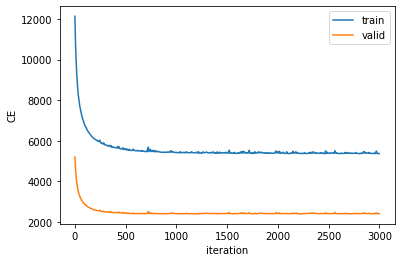

In [ ]:
plt.clf()
plt.plot(np.array(train_ce_logistic), label='train')
plt.plot(np.array(valid_ce_logistic), label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
plt.show()

As can be seen above, the overall cost decreases for both the training and validation datasets, which means we neither overshooted with $α$ or overfit the training data. It is to be noted that the small spikes in cost are due to performing stochastic gradient descent using ADAM (Meaning that the cost can increase from one iteration to another but is decreasing overall).

We'll now do the same for the multiclass regression on the "20 news group" dataset, for the best hyperparameters:

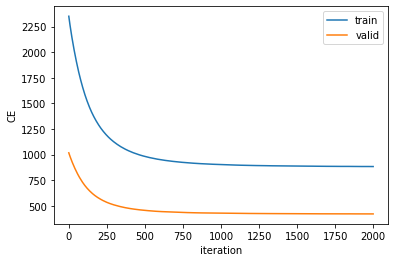

In [ ]:
plt.clf()
plt.plot(np.array(train_ce_multiclass), label='train')
plt.plot(np.array(valid_ce_multiclass), label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
plt.show()

Again, we can see that the model converges, with both the training and validation costs decreasing, which shows no sign of overfitting or overshooting. Also, the small fluctuations with iterations are again due to SGD.

## 4.2 Performing the small perturbation test on both the multiclass and logistic regression gradients

We will perform the small perturbation test at the point defined by the best $\overrightarrow{w}$ for logistic regression. We will use λ = 0.05 arbitrarily since the small perturbation computation works with any function and is a result of the definition of the gradient.

In [ ]:
best_model_logistic.small_perturbation(X_train_imdb, y_train_imdb, lambda_ = 0.05)

Small perturbation test terminates with a difference of 2.9007417288890878e-11.


As can be seen above, we get a small perturbation value of around $3^{-11}$, which validates our gradient and cost functions.

Similary, for multiclass regression:

In [ ]:
best_model_multiclass.small_perturbation(X_train_twenty, y_train_twenty, lambda_ = 0.05)

Small perturbation test terminates with a difference of 1.6288426892140203e-09.


We get a small perturbation value of around $2^{-9}$, as required.

## 4.3 Top 10 Features on the IMDB dataset using +/- z-score

In pre-processing section 1.1, we obtained the following dataframe for the 10 most positive words.

In [ ]:
most_positive_words

,Word,z-score
56,great,46.806802
282,excellent,36.995621
88,best,35.231665
342,wonderful,34.588314
87,love,29.790638
410,loved,28.008016
432,amazing,27.716057
365,perfect,26.721903
466,favorite,26.402529
843,superb,26.072888


We also obtained the following dataframe for the 10 most negative words.

In [ ]:
most_negative_words

,Word,z-score
50,bad,-61.229505
213,worst,-59.187551
400,waste,-46.945639
341,awful,-43.687852
19,?,-39.073873
346,terrible,-38.854331
395,worse,-35.599683
476,horrible,-34.275638
336,stupid,-33.807844
28,no,-33.284108


We can use the above results to build the following bar plots showing the z-scores on the x-axis and the feature names on the y-axis:

Text(0.5, 1.0, 'Bar plot of the 10 most positive / negative words based on their z-scores')

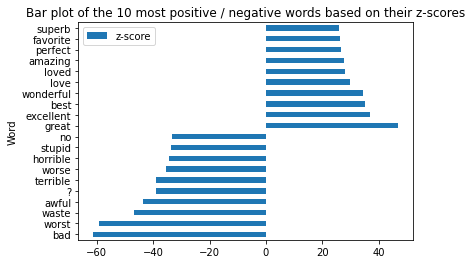

In [ ]:
# Merge the most positive and most negative words
all_words = most_negative_words.append(most_positive_words)

# Build the bar plot
all_words.plot.barh(x="Word", y="z-score")

# Title
plt.title("Bar plot of the 10 most positive / negative words based on their z-scores")

## 4.4 Top 10 features on the IMDB dataset using +/- feature weights of best Logistic Regression model

We'll now plot the same graph as above again, but using the weights of the trained model instead of the z-score on the x-axis. We'll use the best logistic regression model trained in the hyperparameter section, removing the bias row:

In [ ]:
# Extract the best weights without the bias row
best_w = best_model_logistic.w[1:]

We'll start by visualize the 10 most positive words based on the weights:

In [ ]:
# Extract the words with the 10 most positive weights and their respective weights
most_positive_word_indices = np.argsort(-best_w)
most_positive_words = imdb_feature_words.iloc[most_positive_word_indices[0:10]]
most_positive_words["Weight"] = -np.sort(-best_w)[0:10]

# Visualize the 10 most positive words based on the weights
most_positive_words

,Word,Weight
92,wonderfully,1.020076
7,excellent,0.970225
27,perfect,0.837389
194,rare,0.830875
31,superb,0.802288
250,funniest,0.726435
30,favorite,0.712529
24,amazing,0.711653
124,incredible,0.678115
269,tears,0.675400


The results above make sense. We'll now visualize the 10 most negative words based on the weights:

In [ ]:
# Extract the words with the 10 most positive weights and their respective weights
most_negative_word_indices = np.argsort(best_w)
most_negative_words = imdb_feature_words.iloc[most_negative_word_indices[0:10]]
most_negative_words["Weight"] = np.sort(best_w)[0:10]

# Visualize the 10 most positive words based on the weights
most_negative_words

,Word,Weight
2,waste,-1.395881
1,worst,-1.259644
29,poorly,-1.213288
4,awful,-1.067679
190,disappointment,-1.026853
48,laughable,-1.011623
210,disappointing,-0.977836
39,wasted,-0.951918
14,boring,-0.932153
23,avoid,-0.928898


Again, the results are predictive of a negative review. We'll now proceed to plot the bar plot, as was done for the z-scores in section 4.3:

Text(0.5, 1.0, 'Bar plot of the 10 most positive / negative words based on their weights')

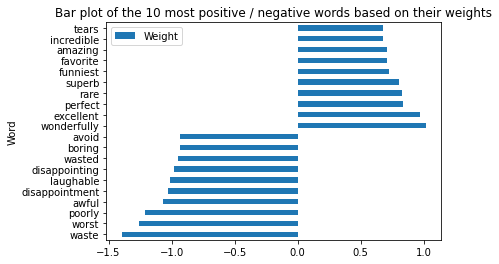

In [ ]:
# Merge the most positive and most negative words
all_words = most_negative_words.append(most_positive_words)

# Build the bar plot
all_words.plot.barh(x="Word", y="Weight")

# Title
plt.title("Bar plot of the 10 most positive / negative words based on their weights")

Note the small scale of the weights as a result of the ridge regularization that was applied to the model.

## 4.5 Analyze and compare logistic regression to KNN on IMDB data

In this section we will compare the results of the sklearn's KNN and our Logistic regression models on the binary classification task for IMDB dataset.

### 4.5.1 ROC of classification of IMDB data

We will start by instantiating the two models with the best hyperparameters found previously. Then, we will proceed by computing the testing predictions and plotting the ROC curves for the two models.

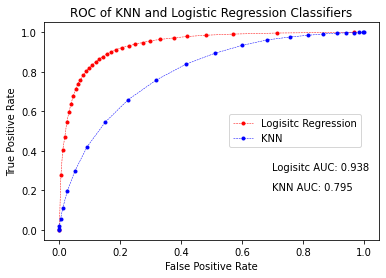

In [ ]:
logreg = LogisticRegression(verbose=False) # Create Multinomial object

# Fit logiistic regression model using best hyperparameters 
fit, _, _, _ = logreg.fit(X_train_imdb, 
                          y_train_imdb, 
                          X_validate_imdb, 
                          y_validate_imdb, 
                          learning_rate=0.005,
                          max_iter=3000,
                          batch_size=100,
                          lambda_=0.05,
                          epsilon=0.003,
                          compute_ce = False)

# Predict using test dataset
y_pred_logreg = fit.predict(X_test_imdb)

# Get false positive and true positive rates for logisitc regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test_imdb, y_pred_logreg)
# Get AUC for logisitc regression
auc_logreg = roc_auc_score(y_test_imdb, y_pred_logreg)


# Instanciate KNN for binary classification
knn_imdb = KNeighborsClassifier(n_neighbors=22, weights='uniform')
knn_imdb_fit = knn_imdb.fit(knn_X_train_imdb, knn_y_train_imdb)

# Compute the hard training predictions
y_pred_knn = knn_imdb_fit.predict_proba(X_test_imdb)

# Get false positive and true positive rates for knn
# Here we only select the probability estimates of the positive class
# because that's the required input for roc_curve()
fpr_knn, tpr_knn, _ = roc_curve(y_test_imdb, y_pred_knn[:, 1])
# Get AUC for knn
auc_knn = roc_auc_score(y_test_imdb, y_pred_knn[:, 1])

# Plot configuration
fig = plt.figure()

# plot the roc curve for the Logistic Regression and KNN models
plt.plot(fpr_logreg[:-1:160], tpr_logreg[:-1:160], marker='.', linestyle="--", lw=0.5, color='red', label="Logisitc Regression")
plt.plot(fpr_knn, tpr_knn, marker='.', linestyle="--", lw=0.5, color='blue', label="KNN")

plt.text(0.7, 0.3, 'Logisitc AUC: '+str(round(auc_logreg,3)))
plt.text(0.7, 0.2, 'KNN AUC: '+str(round(auc_knn,3)))

plt.title("ROC of KNN and Logistic Regression Classifiers")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))
plt.show()

We can see that the ROCAUC of Logistic Regression is `93.8%` while the ROCAUC of KNN is `79.5%`. Our Logistic Regression model outperforms KNN on the classification task on the IMDB dataset by approximately `10%` based on the AUROC result.

Note that sklearn function `roc_curve` returns us unique values for the false positive and true positive rates and we end up with 5120 unique values for the logistic regression and only 24 for the KNN. This is why the red curve appears bolder than the blue one. In order to produce a visually better plot, we will only plot every 160th (FPR, TPR) value for the logistic regression.

### 4.5.1 Accuracy comparison between KNN and Logistic Regression

Here we will compare the training and testing accuracies of sklearn's KNN and logistic regression models. Note that we will not have a validation accuracy comparison since we are already instantiating the two models with the optimal hyperparameters. 

In [ ]:
# KNN accuracies
print(f'The training accuracy of KNN on IMDB data is {round(accuracy_score(knn_y_train_imdb, knn_imdb_train_pred), 3) * 100}%.')
print(f'The testing accuracy of KNN on IMDB data is {round(accuracy_score(y_test_imdb, knn_imdb_test_pred), 3) * 100}%.')

# Compute the training predictions of Logistic Regression
y_pred_train_logreg = fit.predict(X_train_imdb)

# Compute Logistic Regression accuracy
print(f'The training accuracy of Logistic Regression on IMDB data is {round(accuracy_binary(y_train_imdb, y_pred_train_logreg), 3) * 100}%.')
print(f'The testing accuracy of Logistic Regression on IMDB data is {round(accuracy_binary(y_test_imdb, y_pred_logreg), 3) * 100}%.')

The training accuracy of KNN on IMDB data is 75.3%.
The testing accuracy of KNN on IMDB data is 71.1%.
The training accuracy of Logistic Regression on IMDB data is 87.5%.
The testing accuracy of Logistic Regression on IMDB data is 86.7%.


We can summarize the accuracies as follows:
* Training accuracy: `75.3%` for KNN and `87.5%` for Logistic regression
* Testing accuracy: `71.1%` for KNN and `86.7%` for Logistic regression

We can see that our model outperforms sklearn's KNN on binary classification task by approximately `10%` based on the testing accuracy, similarly to the AUROC result.

## 4.6 Analyze and compare multiclass regression to KNN on 20-news-group-dataset

In this section, we will compare the Multiclass Regression and the multiclass KNN classifiers. We will use the best hyperparameters found in the previous sections and compare the testing and training accuracies of the two models. Moreover, we will compute the true positive and false positive rates by visualizing the ROC curves for each predicted class. This way, we will be able to see which class is predicted better or worse.

### 4.6.1 ROC of classification on 20-news-groups data for each class

We will illustrate the ROC curves of KNN multiclass classifier, with the best hyperparameter `k=1`. 

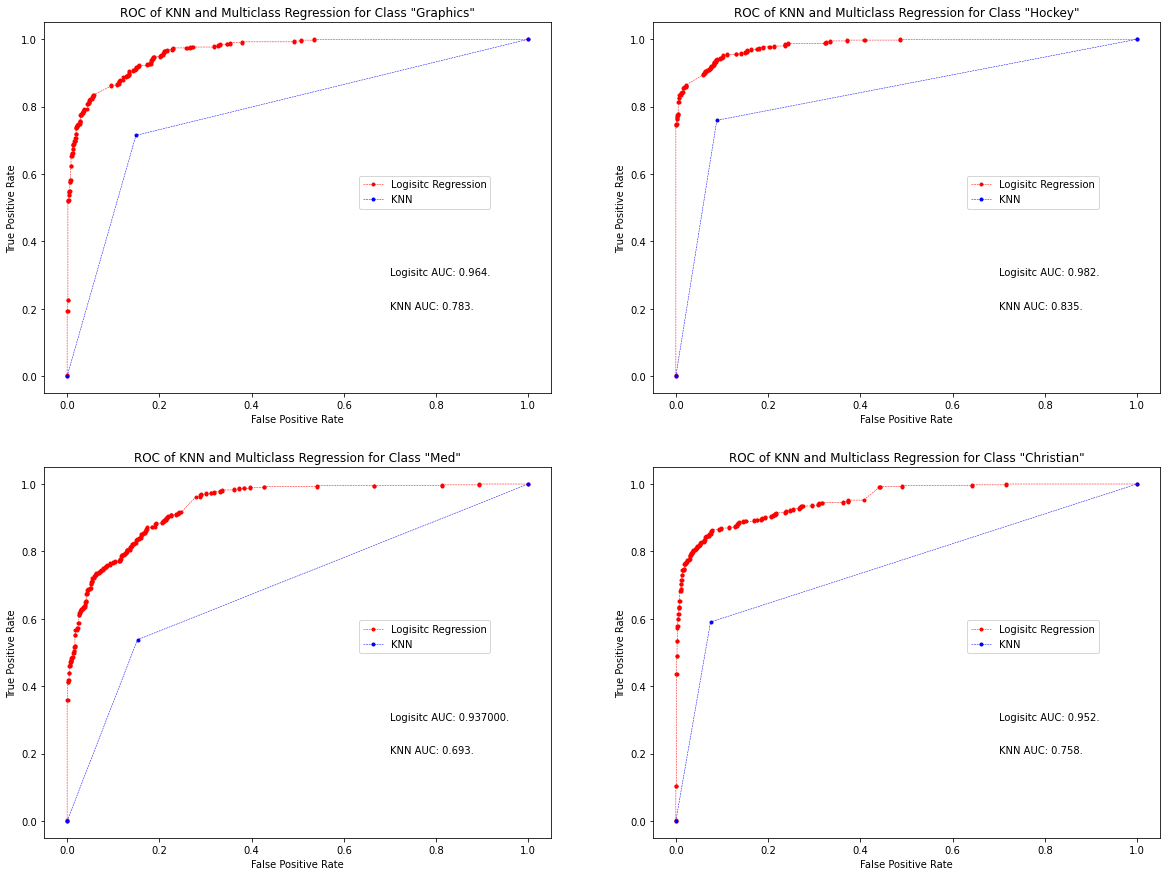

In [ ]:
# Instantiate the Multiclass Regression model
multireg = Multinomial_logistic(verbose=False)

# Fit multiclass regression model using best hyperparameters 
fit, _, _, _ = multireg.fit(X_train_twenty, 
                            y_train_twenty, 
                            X_validate_twenty, 
                            y_validate_twenty, 
                            learning_rate=0.005, 
                            epsilon=0.003, 
                            max_iter=2000, 
                            batch_size=100, 
                            lambda_=0.05,
                            compute_ce = False)


# Predict using test dataset
y_pred_multireg = fit.predict(X_test_twenty)

# Get false positive and true positive rates and auc for multiclass regression 

# Class 0
fpr_multireg_0, tpr_multireg_0, _ = roc_curve(y_test_twenty[:, 0], y_pred_multireg[:, 0])
auc_multireg_0 = roc_auc_score(y_test_twenty[:, 0], y_pred_multireg[:, 0])

# Class 1
fpr_multireg_1, tpr_multireg_1, _ = roc_curve(y_test_twenty[:, 1], y_pred_multireg[:, 1])
auc_multireg_1 = roc_auc_score(y_test_twenty[:, 1], y_pred_multireg[:, 1])

# Class 2
fpr_multireg_2, tpr_multireg_2, _ = roc_curve(y_test_twenty[:, 2], y_pred_multireg[:, 2])
auc_multireg_2 = roc_auc_score(y_test_twenty[:, 2], y_pred_multireg[:, 2])

# Class 3
fpr_multireg_3, tpr_multireg_3, _ = roc_curve(y_test_twenty[:, 3], y_pred_multireg[:, 3])
auc_multireg_3 = roc_auc_score(y_test_twenty[:, 3], y_pred_multireg[:, 3])


# Instanciate KNN for multiclass classification
knn_twenty = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn_twenty_fit = knn_twenty.fit(knn_X_train_twenty, knn_y_train_twenty)

# Compute the hard training predictions
y_pred_knn_twenty = knn_twenty_fit.predict_proba(X_test_twenty)

# Get false positive and true positive rates and auc for KNN

# Class 0
fpr_knn_0, tpr_knn_0, _ = roc_curve(y_test_twenty[:, 0], y_pred_knn_twenty[0][:, 1])
auc_knn_0 = roc_auc_score(y_test_twenty[:, 0], y_pred_knn_twenty[0][:, 1])

# Class 1
fpr_knn_1, tpr_knn_1, _ = roc_curve(y_test_twenty[:, 1], y_pred_knn_twenty[1][:, 1])
auc_knn_1 = roc_auc_score(y_test_twenty[:, 1], y_pred_knn_twenty[1][:, 1])


# Class 2
fpr_knn_2, tpr_knn_2, _ = roc_curve(y_test_twenty[:, 2], y_pred_knn_twenty[2][:, 1])
auc_knn_2 = roc_auc_score(y_test_twenty[:, 2], y_pred_knn_twenty[2][:, 1])


# Class 3
fpr_knn_3, tpr_knn_3, _ = roc_curve(y_test_twenty[:, 3], y_pred_knn_twenty[3][:, 1])
auc_knn_3 = roc_auc_score(y_test_twenty[:, 3], y_pred_knn_twenty[3][:, 1])


# Plot configuration
plt.figure(figsize=(20, 15))

# plot the roc curve for the Multiclass Regression and KNN models

# Class 0
plt.subplot(2, 2, 1)
plt.plot(fpr_multireg_0, tpr_multireg_0, marker='.', linestyle="--", lw=0.5, color='red', label="Logisitc Regression")
plt.plot(fpr_knn_0, tpr_knn_0, marker='.', linestyle="--", lw=0.5, color='blue', label="KNN")

plt.text(0.7, 0.3, 'Logisitc AUC: {:.3f}.'.format(round(auc_multireg_0,3)))
plt.text(0.7, 0.2, 'KNN AUC: {:.3f}.'.format(round(auc_knn_0,3)))
plt.title("ROC of KNN and Multiclass Regression for Class \"Graphics\"")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))


# Class 1
plt.subplot(2, 2, 2)
plt.plot(fpr_multireg_1, tpr_multireg_1, marker='.', linestyle="--", lw=0.5, color='red', label="Logisitc Regression")
plt.plot(fpr_knn_1, tpr_knn_1, marker='.', linestyle="--", lw=0.5, color='blue', label="KNN")

plt.text(0.7, 0.3, 'Logisitc AUC: {:.3f}.'.format(round(auc_multireg_1,3)))
plt.text(0.7, 0.2, 'KNN AUC: {:.3f}.'.format(round(auc_knn_1,3)))
plt.title("ROC of KNN and Multiclass Regression for Class \"Hockey\"")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))


# Class 2
plt.subplot(2, 2, 3)
plt.plot(fpr_multireg_2, tpr_multireg_2, marker='.', linestyle="--", lw=0.5, color='red', label="Logisitc Regression")
plt.plot(fpr_knn_2, tpr_knn_2, marker='.', linestyle="--", lw=0.5, color='blue', label="KNN")

plt.text(0.7, 0.3, 'Logisitc AUC: {:3f}.'.format(round(auc_multireg_2,3)))
plt.text(0.7, 0.2, 'KNN AUC: {:.3f}.'.format(round(auc_knn_2,3)))
plt.title("ROC of KNN and Multiclass Regression for Class \"Med\"")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))


# Class 3
plt.subplot(2, 2, 4)
plt.plot(fpr_multireg_3, tpr_multireg_3, marker='.', linestyle="--", lw=0.5, color='red', label="Logisitc Regression")
plt.plot(fpr_knn_3, tpr_knn_3, marker='.', linestyle="--", lw=0.5, color='blue', label="KNN")

plt.text(0.7, 0.3, 'Logisitc AUC: {:.3f}.'.format(round(auc_multireg_3,3)))
plt.text(0.7, 0.2, 'KNN AUC: {:.3f}.'.format(round(auc_knn_3,3)))
plt.title("ROC of KNN and Multiclass Regression for Class \"Christian\"")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))


plt.show()

We can see that for each class, our Multiclass Classification model predicts approximately 10% to 20% higher AUROC scores than sklearn KNN model on multiclass classification task on 20-news-group dataset. Therefore, our model outperforms KNN.

### 4.6.2 Accuracy comparison between KNN and Multiclass Regression

We will compare accuracies using hard predictions and the optimal hyperparameters for the KNN (i.e. `k=1`) and Multiclass Regression models. 

In [ ]:
# Compute the accuracy of the multiclass KNN 
print(f'The training accuracy of KNN on 20 news groups data is {round(accuracy_score(knn_y_train_twenty, knn_twenty_train_pred), 3) * 100}%.')
print(f'The testing accuracy of KNN on 20 news groups data is {round(accuracy_score(y_test_twenty, knn_twenty_test_pred), 3) * 100}%.')

# Compute the training predictions of Multiclass Regression
y_pred_train_multireg = fit.predict(X_train_twenty)

# Compute Logistic Regression accuracy
print(f'The training accuracy of Multiclass Regression on 20 news groups data is {round(accuracy_multiclass(y_train_twenty, y_pred_train_multireg), 3) * 100}%.')
print('The testing accuracy of Multiclass Regression on 20 news groups data is {:.1f}%.'.format(round(accuracy_multiclass(y_test_twenty, y_pred_multireg), 3) * 100))

The training accuracy of KNN on 20 news groups data is 97.6%.
The testing accuracy of KNN on 20 news groups data is 65.0%.
The training accuracy of Multiclass Regression on 20 news groups data is 89.0%.
The testing accuracy of Multiclass Regression on 20 news groups data is 82.4%.


We can summarize the accuracies as follows:
* Training accuracy: `97.6%` for KNN and `89.0%` for Multiclass regression
* Testing accuracy: `65.0%` for KNN and `82.4%` for Multiclass regression

As mentioned previously, since `GridSearchCV` yielded `k=1` for the optimal number of neighbors, the training accuracty for the KNN model is very high at `97.6%`. This is because it is predicting the class based on the label of a single nearest neighbor. However, the testing accuracy of the KNN is very low at `65.0%`. In contrast, our Multiclass Regression model has both training and testing accuracies at `89.0%` and `82.4%` respectively. We can therefore conclude that our Multiclass Regression model outperforms sklearn KNN for multiclass classification task by approximately `15%` based on the testing accuracy.  


## 4.7 Analyzing model accuracy as a function of training dataset size

We now compare the accuracy of the two models as a function of the size
of dataset (by controlling the training size). We will randomly select 20%,
40%, 60% and 80% of the available training data and train both models on these distinct subsets. We will then evaluate the trained models by plotting the accuracies depending on the size for training, validation and test sets.

We create an array to store the different sizes of the training dataset.

In [ ]:
# Array storing the different sizes of the training dataset to compare accuracies
training_sizes = [0.2, 0.4, 0.6, 0.8, 1]

### 4.7.1 Logistic regression

We will evaluate how the accuracy of logistic regression & KNN varies if we change the size of the training data. We will start by training with different sizes using the optimal hyperparameters from section 3.

In [ ]:
# Since we validated already, we restore the full training set
X_train_full = np.vstack((X_train_imdb, X_validate_imdb))
y_train_full = np.concatenate((y_train_imdb, y_validate_imdb))

# To hold the accuracies corresponding to each size
training_accuracies_logistic = test_accuracies_logistic = np.empty(0)
training_accuracies_knn = test_accuracies_knn = np.empty(0)

# To hold the AUROCs corresponding to each size
AUROCs_logistic = np.empty(0)
AUROCs_knn = np.empty(0)

# Loop over each possible training size
for i in training_sizes:
  
  # Split the training data we obtain after the pre-processing using the sizes stored in the array: 20%, 40%, 60% and 80%
  if i != 1: _, X_train, _, y_train = train_test_split(X_train_full, y_train_full, test_size = i, random_state=5, shuffle = True)
  else: X_train, y_train = X_train_full, y_train_full
  
  # Fit the model with the optimal hyperparameters found before
  model, _, _, _ = LogisticRegression(verbose=False).fit(X_train,
                                                         y_train,
                                                         np.empty(0), 
                                                         np.empty(0), 
                                                         learning_rate=0.005,
                                                         max_iter=3000,
                                                         batch_size=100,
                                                         lambda_=0.05,
                                                         epsilon=0.003,
                                                         compute_ce = False
                                                        ) 
  
  # Fit KNN with the optimal hyperparameter found before
  knn_fit = KNeighborsClassifier(n_neighbors=22, weights = "uniform").fit(X_train, y_train)

  # Predict the AUROCs of the positive class using KNN (For AUROC later)
  AUROCs_logistic = np.append(AUROCs_logistic, roc_auc_score(y_test_imdb, model.predict(X_test_imdb)))
  AUROCs_knn = np.append(AUROCs_knn, roc_auc_score(y_test_imdb, knn_fit.predict_proba(X_test_imdb)[:, 1]))

  # Evaluate the accuracy on training and testing datasets and append the results to the corresponding arrays
  training_accuracies_logistic = np.append(training_accuracies_logistic, accuracy_binary(y_train, model.predict(X_train)))
  test_accuracies_logistic = np.append(test_accuracies_logistic, accuracy_binary(y_test_imdb, model.predict(X_test_imdb)))
  training_accuracies_knn = np.append(training_accuracies_knn, accuracy_score(y_train, knn_fit.predict(X_train)))
  test_accuracies_knn= np.append(test_accuracies_knn, accuracy_score(y_test_imdb, knn_fit.predict(X_test_imdb)))

We will now proceed to plot the results as a line plot.

Text(0.5, 1.0, 'Accuracy depending on the training size')

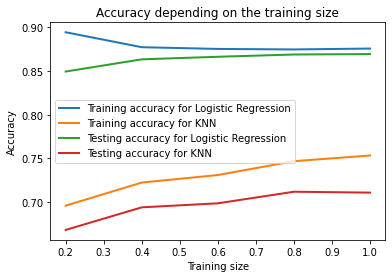

In [ ]:
# Plot the training accuracies depending on the training data size
plt.plot(training_sizes, training_accuracies_logistic, linewidth=2.0, label="Training accuracy for Logistic Regression")
plt.plot(training_sizes, training_accuracies_knn, linewidth=2.0, label="Training accuracy for KNN")

# Plot the testing accuracies depending on the training data size
plt.plot(training_sizes, test_accuracies_logistic, linewidth=2.0, label="Testing accuracy for Logistic Regression")
plt.plot(training_sizes, test_accuracies_knn, linewidth=2.0, label="Testing accuracy for KNN")

# Label the graph
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.title("Accuracy depending on the training size")

Plotting those same results as a bar plot, we get:

Text(0.5, 1.0, 'Accuracy depending on the training size')

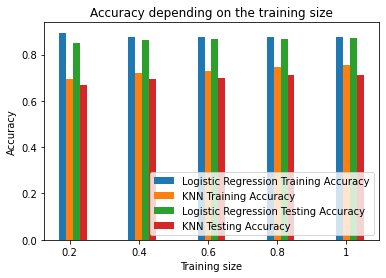

In [ ]:
# To plot the different bars
ind = np.arange(5)

# Plot the training accuracies depending on the training data size
plt.bar(ind-0.2, training_accuracies_logistic, width=0.1, label="Logistic Regression Training Accuracy")
plt.bar(ind-0.1, training_accuracies_knn, width=0.1, label="KNN Training Accuracy")

# Plot the testing accuracies depending on the training data size
plt.bar(ind, test_accuracies_logistic, width=0.1, label="Logistic Regression Testing Accuracy")
plt.bar(ind+0.1, test_accuracies_knn, width=0.1, label="KNN Testing Accuracy")

# Set the labels of the x-axis
plt.xticks(ind-0.1, labels=training_sizes)

# Label the graph
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.title("Accuracy depending on the training size")

Using the above charts, we notice that for logistic regression training accuracy decreases as the training set size increases. While the testing accuracy increases as the training set size increases. Conversely, for KNN, both the training and testing accuracies increase as the training set size increases.

Finally, we will plot the AUROC's of KNN and Logistic Regression as a function of the training set size, in bar plot form.

Text(0.5, 1.0, 'AUROCs depending on the training size')

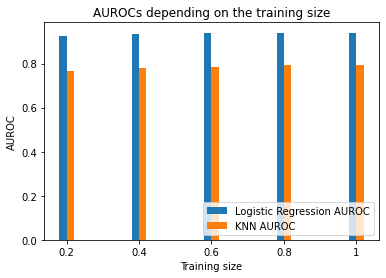

In [ ]:
# To plot the different bars
ind = np.arange(5)

# Plot the Logistic Regression AUROCs depending on the training data size
plt.bar(ind-0.1, AUROCs_logistic, width=0.1, label="Logistic Regression AUROC")

# Plot the KNN AUROCs depending on the training data size
plt.bar(ind, AUROCs_knn, width=0.1, label="KNN AUROC")
# Set the labels of the x-axis
plt.xticks(ind-0.05, labels=training_sizes)

# Label the graph
plt.xlabel('Training size')
plt.ylabel('AUROC')
plt.legend(loc="lower right")
plt.title("AUROCs depending on the training size")

Plotting them as line plots to better see the differences:

Text(0.5, 1.0, 'AUROCs depending on the training size')

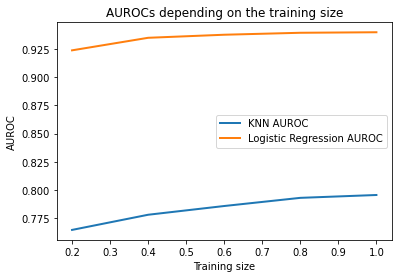

In [ ]:
# Plot the KNN AUROC depending on the training data size
plt.plot(training_sizes, AUROCs_knn, linewidth=2.0, label="KNN AUROC")

# Plot the Logistic Regression AUROC depending on the training data size
plt.plot(training_sizes, AUROCs_logistic, linewidth=2.0, label="Logistic Regression AUROC")

# Label the graph
plt.xlabel('Training size')
plt.ylabel('AUROC')
plt.legend(loc="best")
plt.title("AUROCs depending on the training size")


We can see that both increase, as expected, since more data means better testing accuracy.

### 4.7.2 Multiclass Regression

We will now evaluate how the accuracy of multicass regression & KNN varies if we change the size of the training data. We will start by training with different sizes using the optimal hyperparameters from section 3.

In [ ]:
# Since we validated already, we restore the full training set
X_train_full = np.vstack((X_train_twenty, X_validate_twenty))
y_train_full = np.concatenate((y_train_twenty, y_validate_twenty))

# To hold the accuracies corresponding to each size
training_accuracies_multiclass = test_accuracies_multiclass = np.empty(0)
training_accuracies_knn = test_accuracies_knn = np.empty(0)

# Loop over each possible training size
for i in training_sizes:
  
  # Split the training data we obtain after the pre-processing using the sizes stored in the array: 20%, 40%, 60% and 80%
  if i != 1: _, X_train, _, y_train = train_test_split(X_train_full, y_train_full, test_size = i, random_state=5, shuffle = True)
  else: X_train, y_train = X_train_full, y_train_full
  
  # Fit the model with the optimal hyperparameters found before
  model, _, _, _ = Multinomial_logistic(verbose=False).fit(X_train,
                                                         y_train,
                                                         np.empty(0), 
                                                         np.empty(0), 
                                                         learning_rate=0.005,
                                                         max_iter=2000,
                                                         batch_size=100,
                                                         lambda_=0.05,
                                                         epsilon=0.003,
                                                         compute_ce = False
                                                        ) 
  
  # Fit KNN with the optimal hyperparameter found before
  knn_fit = KNeighborsClassifier(n_neighbors=1, weights = "uniform").fit(X_train, y_train)

  # Evaluate the accuracy on training and testing datasets and append the results to the corresponding arrays
  training_accuracies_multiclass = np.append(training_accuracies_multiclass, accuracy_multiclass(y_train, model.predict(X_train)))
  test_accuracies_multiclass = np.append(test_accuracies_multiclass, accuracy_multiclass(y_test_twenty, model.predict(X_test_twenty)))
  training_accuracies_knn = np.append(training_accuracies_knn, accuracy_score(y_train, knn_fit.predict(X_train)))
  test_accuracies_knn= np.append(test_accuracies_knn, accuracy_score(y_test_twenty, knn_fit.predict(X_test_twenty)))

We will now proceed to plot the results as a line plot.

Text(0.5, 1.0, 'Accuracy depending on the training size')

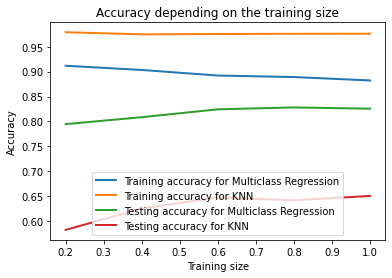

In [ ]:
# Plot the training accuracies depending on the training data size
plt.plot(training_sizes, training_accuracies_multiclass, linewidth=2.0, label="Training accuracy for Multiclass Regression")
plt.plot(training_sizes, training_accuracies_knn, linewidth=2.0, label="Training accuracy for KNN")

# Plot the testing accuracies depending on the training data size
plt.plot(training_sizes, test_accuracies_multiclass, linewidth=2.0, label="Testing accuracy for Multiclass Regression")
plt.plot(training_sizes, test_accuracies_knn, linewidth=2.0, label="Testing accuracy for KNN")

# Label the graph
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.title("Accuracy depending on the training size")

Plotting those same results as a bar plot, we get:

Text(0.5, 1.0, 'Accuracy depending on the training size')

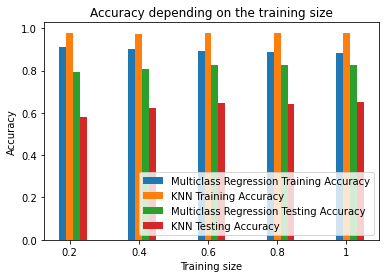

In [ ]:
# To plot the different bars
ind = np.arange(5)

# Plot the training accuracies depending on the training data size
plt.bar(ind-0.2, training_accuracies_multiclass, width=0.1, label="Multiclass Regression Training Accuracy")
plt.bar(ind-0.1, training_accuracies_knn, width=0.1, label="KNN Training Accuracy")

# Plot the testing accuracies depending on the training data size
plt.bar(ind, test_accuracies_multiclass, width=0.1, label="Multiclass Regression Testing Accuracy")
plt.bar(ind+0.1, test_accuracies_knn, width=0.1, label="KNN Testing Accuracy")

# Set the labels of the x-axis
plt.xticks(ind-0.1, labels=training_sizes)

# Label the graph
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.title("Accuracy depending on the training size")

Using the above charts, we conclude that, similarly, training accuracy for Multiclass regression decreases as the training set size increases, while testing accuracy increases. Conversely, for KNN, training accuracy stays very high as training set size increases, while testing accuracy seems to increase. This is once again, due to the best `k` hyperparameter yielded by `GridSearchCV` being equal to 1. 


From the above experiments, we can conclude that increasing the training set size increases both the training and testing accuracies of KNN, while it increases the testing accuracies of the linear predictors and decreases their training accuracies.

## 4.8 Heatmap showing the top 5 features of multiclass classification from the 20-news-groups dataset

We now plot a heatmap showing the top 5 most positive features as rows and 4 chosen classes from the 20-news-groups dataset as columns in the multi-class classification. 

We use the learned weights in `W` from the multiclass regression model. The W matrix is of the size $D \times 4$ (i.e. number of features by 4) because we only kept 4 news categories. Then, for each of the 4 classes, we seek out the top 5 values in `W` with the highest weights. The heatmap will then be of $20 \times 4$ dimension showing the top 5 most positive features for each of the 4 classes.

(297, 4)


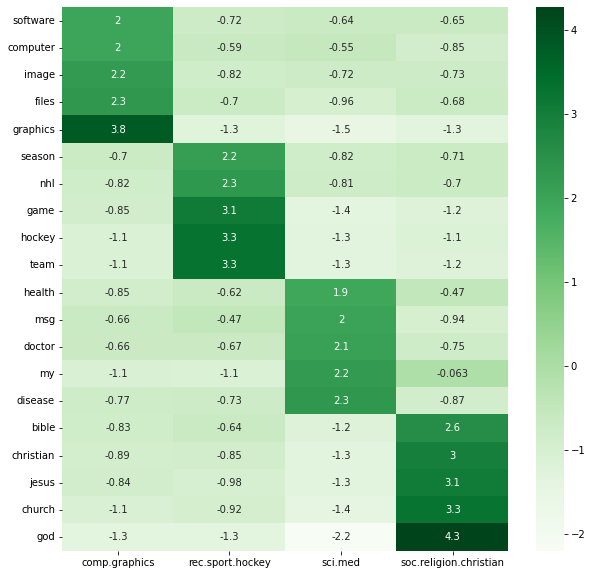

In [ ]:
import seaborn as sns # Heatmaps

# Fit the model with the optimal hyperparameters found before
model, _, _, _ = Multinomial_logistic(verbose=False).fit(X_train_twenty,
                                                      y_train_twenty,
                                                      X_validate_twenty,
                                                      y_validate_twenty,
                                                      learning_rate=0.005,
                                                      max_iter=2000,
                                                      batch_size=100,
                                                      lambda_=0.05,
                                                      epsilon=0.003,
                                                      compute_ce = False
                                                      )

learned_weigths = model.W

# Remove the bias column
learned_weigths = learned_weigths[1:]

# Chekc the size of the learned_weigths array (should be (297,4))
print(learned_weigths.shape)



most_positive_features_matrix = np.empty((20, 4))
y_label_map = np.empty(0)

i = 0

# Iterate over each column of the learned weights matrix
for column in learned_weigths.T:
  # get 5 highest values in the column
  ind = np.argpartition(column, -5)[-5:]

  for index in ind:
    most_positive_features_matrix[i] = learned_weigths[index]
    y_label_map = np.append(y_label_map, feature_names_twenty[index])
    i +=1

plt.figure(figsize=(10,10))
sns.heatmap(most_positive_features_matrix, xticklabels = categories_twenty, yticklabels = y_label_map, cmap="Greens", annot=True) # Draw the heatmap with the mask using the sns library
plt.show()

The 5 most positive features for class Graphics are: file, image, graphics, files and computer. For class Hockey they are: season, nhl, game, hockey, team. For class Med they are: health, msg, doctor, my, disease. Finally for class Christian they are: bible, christian, jesus, god and church. The most important feature of the whole model is "god" with weight 4.2. 
We also notice that categories have very distinct because none of them have the same top positive features.

We will also plot the top 5 most negative features per category on a same heatmap.

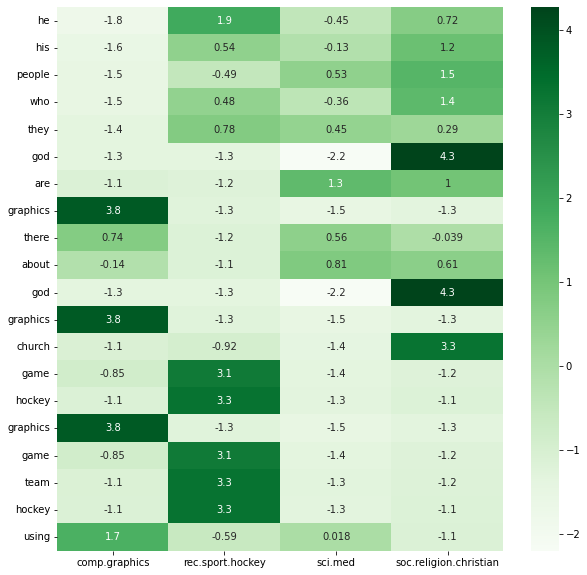

In [ ]:
most_negative_features_matrix = np.empty((20, 4))
y_label_map = np.empty(0)

i = 0

# Iterate over each column of the learned weights matrix
for column in learned_weigths.T:
  # get 5 lowest values in the column
  ind = np.argpartition(column, 5)[:5]

  for index in ind:
    most_negative_features_matrix[i] = learned_weigths[index]
    y_label_map = np.append(y_label_map, feature_names_twenty[index])
    i +=1

plt.figure(figsize=(10,10))
sns.heatmap(most_negative_features_matrix, xticklabels = categories_twenty, yticklabels = y_label_map, cmap="Greens", annot=True) # Draw the heatmap with the mask using the sns library
plt.show()

To conclude, the 5 most negative features for class Graphics are: he, his, people, who, they. For class Hockey they are: god, are, graphics, about, there. For class Med they are: god, graphics, church, game, hockey. Finally for class Christian they are: graphics, game, team, hockey and using. Indeed, these words do not hold any semantic relationship with their respective classes.


# References

* [1] https://ai.stanford.edu/~amaas/data/sentiment/

* [2] https://stackoverflow.com/questions/66315038/add-1-to-numpy-array-from-a-list-of-indices

* [3] https://stackoverflow.com/questions/54413874/zero-several-columns-in-csr-matrix

* [4] https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

* [5] https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c 

* [6] https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275 

* [7] https://towardsdatascience.com/select-features-for-machine-learning-model-with-mutual-information-534fe387d5c8

* [8] https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

* [9] https://arxiv.org/abs/1412.6980

* [10] https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/

* [11] https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a

* [12] https://madalinabuzau.github.io/2016/11/29/gradient-descent-on-a-softmax-cross-entropy-cost-function.html

* [13] https://realpython.com/knn-python/

